In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from piston_1 import DMDPiston
from waveoptics.plots.plots import complex_imshow
from dmdholo.fields_propagation.fourier_filter import fourier_filter
from dmdholo.holograms.dmd_holograms import parallel_lee,  orthogonal_lee, holo_SP, holo_Haskell
from dmdholo.holograms.generate_LUT import generate_lut
from dmdholo.plotting.plot_funs import colorize
from thorlabscam.camera import ThorlabsCamera


## Prepare camera

In [2]:
# # cam init
cam = ThorlabsCamera(serial_number='24140', name='CAM_1')
cam.setup(
    exposure_time_us=1500,
    roi_xy_size=(304,304),# (W,H)
    roi_xy_upper_left=(1292,1560),#roi_Origine_X,Y_
    frames_per_trigger_zero_for_unlimited= 1,
    operation_mode=1,trigger_polarity = '1',
    ) 


Available cameras: ['24140']
Current Operation Mode: OPERATION_MODE.HARDWARE_TRIGGERED
Current Trigger Polarity (0: ACTIVE_H): 1


In [31]:
cam.dispose()

## Prepare DLP

In [3]:
import numpy as np
from ALP4 import *

In [4]:
import time
# Load the Vialux .dll
DMD = ALP4(version='4.3', libDir=r"C:\Users\Public\Documents\ALP-4.3\ALP-4.3 API")
DMD.Initialize()  # 0 pour le premier appareil, sinon essayez 1



Loading library: C:\Users\Public\Documents\ALP-4.3\ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1024 x 768.


In [ ]:
DMD.Free()

# LUT Calculation 

## Px=4

In [2]:
px = 4
nuvec = np.array((1/px,1/px**2)) 
SA_filter = 1.0*np.linalg.norm(nuvec)/6
f_val, px_comb, lut = generate_lut('sp', px)

## Px=2

In [ ]:
px = 2
nuvec = np.array((1/px,1/px**2)) 
SA_filter = 1.0*np.linalg.norm(nuvec)/6
f_val, px_comb, lut = generate_lut('sp', px)

# HOLO (Actuators) 

## Generation 

In [3]:
DMD_nSizeY=768
DMD_nSizeX=1024
n_actu_1D = 16
roi_size=256
# Initialisation du DMD avec une région d'intérêt (ROI)
dmd = DMDPiston(n_actu_1D, roi_size=roi_size, roi_shifts=(370, 520))  # H,V (400,520)

# Génération d'hologrammes
nbr_holos = 45000
Holos_Actu = []
maps=[]
generated_fields = set()
for i in range(nbr_holos):  # Correction de `np.(nbr_holos)` en `range(nbr_holos)`
    # Générer des champs avec des amplitudes et phases aléatoires
    dmd.generate_fields(n_actu_1D, rand_amp=True, rand_phi=True,phi_clx=None,phi=None)
    target_field = np.copy(dmd.field_matrix)
    
    # field_hash = hash(dmd.actus.tobytes())
    # if field_hash in generated_fields:
    #     print(f"Duplicate found! in {i}")
    # generated_fields.add(field_hash)
    
    target_field /= np.max(np.abs(target_field))
    # Conversion en hologramme
    holo_sp = holo_SP(target_field, lut, px_comb).astype(np.uint8)
    holo_sp=holo_sp*(2**8-1)
    Holos_Actu.append(holo_sp)
    if i % 100 == 0:
        print("Progress: Generated holograms =", i)

Progress: Generated holograms = 0
Progress: Generated holograms = 100
Progress: Generated holograms = 200
Progress: Generated holograms = 300
Progress: Generated holograms = 400
Progress: Generated holograms = 500
Progress: Generated holograms = 600
Progress: Generated holograms = 700
Progress: Generated holograms = 800
Progress: Generated holograms = 900
Progress: Generated holograms = 1000
Progress: Generated holograms = 1100
Progress: Generated holograms = 1200
Progress: Generated holograms = 1300
Progress: Generated holograms = 1400
Progress: Generated holograms = 1500
Progress: Generated holograms = 1600
Progress: Generated holograms = 1700
Progress: Generated holograms = 1800
Progress: Generated holograms = 1900
Progress: Generated holograms = 2000
Progress: Generated holograms = 2100
Progress: Generated holograms = 2200
Progress: Generated holograms = 2300
Progress: Generated holograms = 2400
Progress: Generated holograms = 2500
Progress: Generated holograms = 2600
Progress: Gen

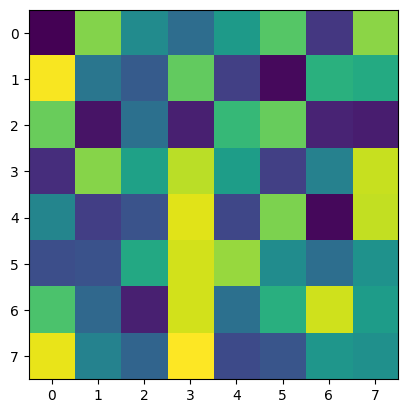

In [38]:
plt.imshow(np.abs(maps[10]))

## Saving the holos in a folder 

In [4]:
np.savez(rf'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size={nbr_holos}_1D_{n_actu_1D}_ROI{roi_size}.npz',
         Holos_Actu=np.array(Holos_Actu))
        #  phase_maps_set=generated_fields)


## plot Expl

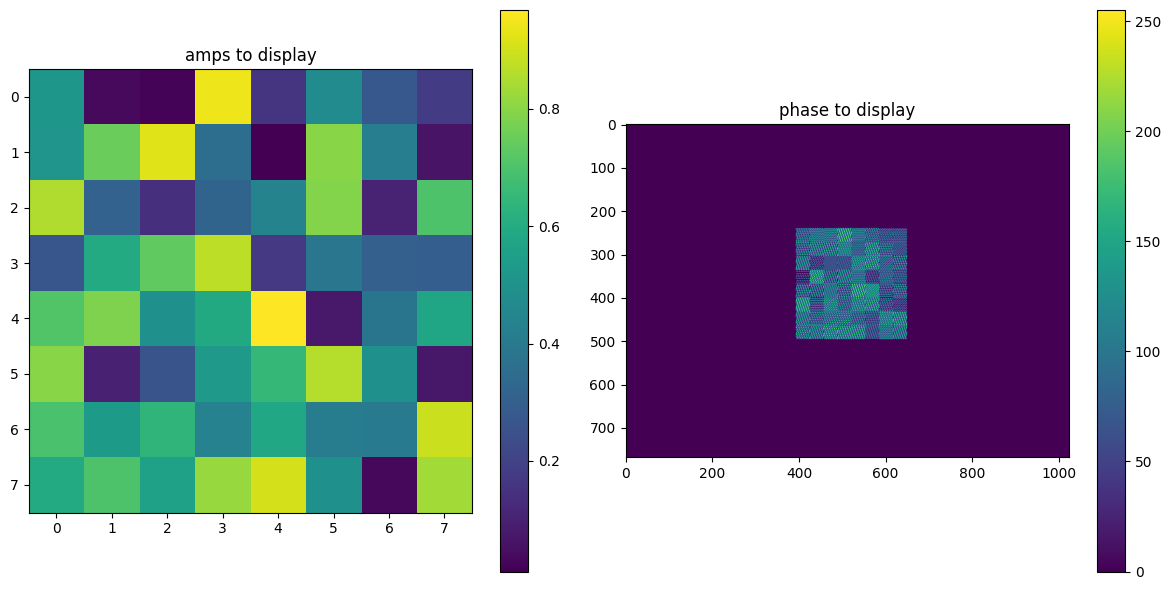

In [44]:
Holos_Actu=np.load(rf"C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256.npz")
plt.figure(figsize=(12, 6))
        
# Amplitude visualization
plt.subplot(1, 2, 1)
plt.title("amps to display")
plt.imshow(np.abs(Holos_Actu["phase_maps"][0]))
plt.colorbar()

# Phase visualization
plt.subplot(1, 2, 2)
plt.title("phase to display")
plt.imshow(np.abs(Holos_Actu["Holos_Actu"][0]))
plt.colorbar()

plt.tight_layout()
plt.show()

### check holos 

In [45]:
single_image=Holos_Actu["Holos_Actu"][0]
print("Image unique shape:", single_image.shape)
print("Image unique dtype:", single_image.dtype)
print("Image unique min/max:", single_image.min(), single_image.max())

Image unique shape: (768, 1024)
Image unique dtype: uint8
Image unique min/max: 0 255


# Affichage du dset en mode Slave NO threads

In [ ]:
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_FALLING) 
data = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256.npz')
Holos_Actu = data['Holos']
# Normalisation des données
Holos_Actu = (Holos_Actu * 255).astype(np.uint8)

# Extraction d'une image unique
single_image = Holos_Actu[0].ravel()
print("Image unique shape:", single_image.shape)
print("Image unique dtype:", single_image.dtype)
print("Image unique min/max:", single_image.min(), single_image.max())

# DMD.SeqAlloc(1)
# DMD.SeqPut(single_image)
# DMD.SetTiming(pictureTime=4000)
# DMD.Run(loop=True)

imgSeq = np.concatenate([img.ravel() for img in Holos_Actu])
DMD.SeqAlloc(len(Holos_Actu))
DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=4000)
cam.run()
cam.get_snapshot_hardware_trigger(
    save_directory=f"./captured_frames_{time.time()}",
    display_timer=True,
    max_get_frame=10,  # Nombre d'images à capturer
    debug=True,
)
DMD.Run(loop=False)




Image unique shape: (786432,)
Image unique dtype: uint8
Image unique min/max: 0 255
SequenceId =  c_long(14)
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Frame 1:
  Frame count: 1
  Time stamp: 17171872935616
  Saved to: ./captured_frames_1736871278.824838\frame_0_17171872935616.npy
Frame 2:
  Frame count: 2
  Time stamp: 17171891989616
  Saved to: ./captured_frames_1736871278.824838\frame_1_17171891989616.npy
Frame 3:
  Frame count: 3
  Time stamp: 17171911040292
  Saved to: ./captured_frames_1736871278.824838\frame_2_17171911040292.npy
Frame 4:
  Frame count: 4
  Time stamp: 17171930089454
  Saved to: ./captured_frames_1736871278.824838\frame_3_17171930089454.npy
Frame 5:
  Frame count: 5
  Time stamp: 17171949136525
  Saved to: ./captured_frames_1736871278.824838\frame_4_17171949136525.npy
Frame 6:
  Frame count: 6
  Time stamp: 17171968183414
  Saved to: ./captured_frames_1736871278.824838\frame_5_17171968183414.npy
Frame 7:
  Frame count: 7
  Time 

In [25]:
cam.device.disarm()
DMD.Halt()

# Successful tests 

### ça Marche (une seule image plate en boucle )

In [48]:

DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_FALLING)  # Set rising edge triggering
nSizeY, nSizeX = 768, 1024  
imgTest = np.ones((nSizeY, nSizeX), dtype=np.uint8) * 255
imgTest_flat = imgTest.ravel()

DMD.SeqAlloc(nbImg = 1, bitDepth = 1)
DMD.SeqPut(imgTest_flat)
DMD.SetTiming( pictureTime=4000)
cam.run()
cam.get_snapshot_hardware_trigger(
    save_directory=f"./captured_frames{time.time()}",
    display_timer=True,
    max_get_frame=100,
    debug=True,
)
DMD.Run(loop=True)

SequenceId =  c_long(21)
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Frame count: 1
Time stamp: 12468421748545
Frame saved to: ./captured_frames1736866575.2989552\frame_12468421748545.npy
Acquisition time: 1001.8348693847656 us


### ça Marche ( seq de 2 images en boucle)

In [ ]:

DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING)  # Set rising edge triggering
DMD.SeqAlloc(nbImg = 2, bitDepth = 1)

# Dimensions du DMD
nSizeY, nSizeX = 768, 1024

imgBlack = np.zeros((nSizeY, nSizeX), dtype=np.uint8)
imgWhite = np.ones((nSizeY, nSizeX), dtype=np.uint8) * 255
imgSeq = np.concatenate([imgBlack.ravel(), imgWhite.ravel()])

DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=10000)
cam.run()
cam.get_snapshot_hardware_trigger(
    save_directory=f"./captured_frames{time.time()}",
    display_timer=True,
    max_get_frame=10,
    debug=True,
)
DMD.Run(loop=True)

# THreads with B&W imgs


In [21]:
import threading
import time

nSizeY, nSizeX = 768, 1024

DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING)  
DMD.SeqAlloc(nbImg=2, bitDepth=1)


imgBlack = np.zeros((nSizeY, nSizeX), dtype=np.uint8)
imgWhite = np.ones((nSizeY, nSizeX), dtype=np.uint8) * 255
imgSeq = np.concatenate([imgBlack.ravel(), imgWhite.ravel()])

DMD.SeqPut(imgSeq)
DMD.SetTiming(pictureTime=10000)

# Lancer la capture dans un thread séparé
save_directory = f"./captured_frames 2"
save_thread = threading.Thread(target=save_frames, args=(cam, save_directory))

cam.run()
# Démarrer le thread pour la capture des images
save_thread.start()
# Démarrer la projection du DMD
DMD.Run(loop=True)
# Attendre que le thread de sauvegarde termine
save_thread.join()

cam.device.disarm()
DMD.Halt()


SequenceId =  c_long(5)
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Frame 1 not captured after 1 attempts.
Skipping frame 1 due to timeout.
Total acquisition time: 1006679.30 µs
Error: No frames were captured!


# HOLOS_CHIFFRES

### generaation des images de chiffres en png 

In [32]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# Taille de l'image
image_height = 768
image_width = 1024

# Répertoire de sauvegarde des images
save_directory = "./digit_images"
os.makedirs(save_directory, exist_ok=True)

font_size = 300
font_path = "arial.ttf"
try:
    font = ImageFont.truetype(font_path, font_size)
except IOError:
    print(f"Erreur : Impossible de charger la police '{font_path}'. Veuillez vérifier le chemin.")
    raise

# Génération des images
for digit in range(0, 10):  # Chiffres de 0 à 9
    # Créer une image vide (noire)
    image = Image.new("L", (image_width, image_height), 0)
    draw = ImageDraw.Draw(image)
    
    # Taille du texte
    text = str(digit)
    bbox = font.getbbox(text)  # Obtenir les dimensions de la bounding box
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculer les coordonnées pour centrer le texte
    x = (image_width - text_width) // 2
    y = (image_height - text_height) // 2
    
    # Dessiner le texte (blanc, valeur 255)
    draw.text((x, y), text, fill=255, font=font)
    
    # Convertir l'image PIL en tableau NumPy
    image_array = np.array(image, dtype=np.float32)
    
    # Normaliser l'image (entre 0 et 1) avant d'appliquer holo_SP
    image_array /= np.max(image_array)
    
    # Générer l'hologramme (hypothèse : la fonction holo_SP est définie)
    image_holo = holo_SP(image_array, lut, px_comb)  # Fonction personnalisée
    
    # Convertir l'hologramme en uint8
    image_holo_uint8 = (image_holo * 255).astype(np.uint8)
    
    # Sauvegarder l'image en tant que fichier PNG
    output_image = Image.fromarray(image_holo_uint8)
    output_image.save(os.path.join(save_directory, f"digit_{digit}.png"))

print(f"Images des chiffres de 0 à 9 générées et sauvegardées dans : {save_directory}")


Images des chiffres de 0 à 9 générées et sauvegardées dans : ./digit_images


### images png to .npz => unit8, min/max: 0 255

In [38]:
save_directory = "./digit_images"
chiffres = []

for digit in range(0,10):  # De 1 à 10
    image_path = os.path.join(save_directory, f"digit_{digit}.png")
    if os.path.exists(image_path):  
        
        image = Image.open(image_path)
        image_array = np.array(image, dtype=np.uint8)
        chiffres.append(image_array)
    else:
        print(f"Image non trouvée : {image_path}")


print(f"Nombre d'images chargées : {len(chiffres)}")
for i, img in enumerate(chiffres):
    print(f"Image {i+1}: shape={img.shape}, dtype={img.dtype}")
np.savez(f'C:\\Users\\gharbi\\Coding\\DLP-Shaping_Main\\holo_chiffres_0 to {len(chiffres)}.npz', 
         chiffres=np.array(chiffres))

Nombre d'images chargées : 10
Image 1: shape=(768, 1024), dtype=uint8
Image 2: shape=(768, 1024), dtype=uint8
Image 3: shape=(768, 1024), dtype=uint8
Image 4: shape=(768, 1024), dtype=uint8
Image 5: shape=(768, 1024), dtype=uint8
Image 6: shape=(768, 1024), dtype=uint8
Image 7: shape=(768, 1024), dtype=uint8
Image 8: shape=(768, 1024), dtype=uint8
Image 9: shape=(768, 1024), dtype=uint8
Image 10: shape=(768, 1024), dtype=uint8


### check holos 

Image unique shape: (768, 1024)
Image unique dtype: uint8
Image unique min/max: 0 255


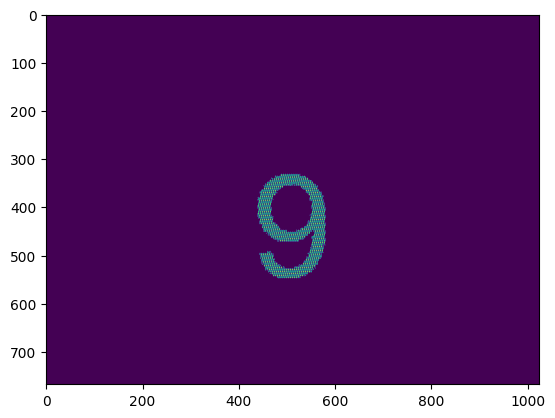

In [29]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_chiffres_0 to 10.npz')
chiffres = data['chiffres']
single_image=chiffres[9]
print("Image unique shape:", single_image.shape)
print("Image unique dtype:", single_image.dtype)
print("Image unique min/max:", single_image.min(), single_image.max())
plt.imshow(chiffres[9])

Contenu du fichier .npz :
Clé : amps
Valeur : [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3
 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8 0.8 0.8
 0.8 

Text(0.5, 1.0, 'rotated noise ')

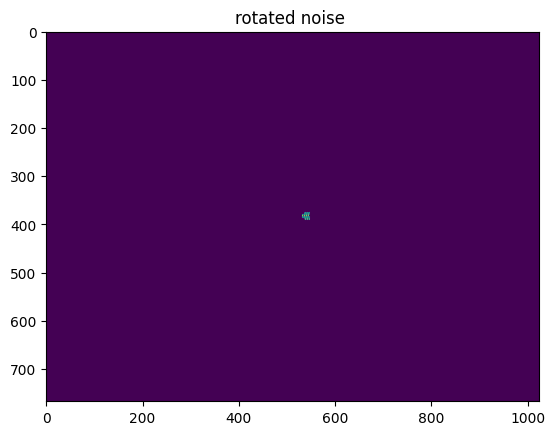

In [14]:
from fonctions_utiles import extract_npz_content as npz
npz(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_Young_Amp_Phase.npz')

# Trigg Signal Init

In [6]:
import serial
import time
import matplotlib.pyplot as plt

# the function to send a trigger
# don't forget the carriage return!
def startTrigger(ser):
    ser.write(b"T" + b'\r')

def stopTrigger(ser):
    ser.write(b"S" + b'\r')

# open serial port
ser = serial.Serial('COM3')  # Assurez-vous que 'COM3' est bien le port série correct
stopTrigger(ser)


In [46]:
# Close the serial port to release it
ser.close()
print("Port COM3 is released.")

Port COM3 is released.


# Threading Func

In [7]:
import datetime
date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


def save_frames(cam, max_get_frame=10, debug=True):
    try:
        cam.get_snapshot_hardware_trigger(
            save_path = f"./captured_frames{date_str}",
            display_timer=True,
            max_get_frame=max_get_frame,
            debug=debug
        )
    except ValueError as e:
        print(f"Error: {e}")
        
def save_check_frames(cam, max_get_frame=10, debug=True):
    try:
        cam.get_snapshot_hardware_trigger(
            save_path=rf'./check_frames_at_{date_str}',
            display_timer=True,
            max_get_frame=max_get_frame,
            debug=debug
        )
    except ValueError as e:
        print(f"Error: {e}")

# Display in thread

In [20]:
import threading
date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING) 
ins = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256_updated.npz')
Holos_num = ins['Holos_Actu'][:10]
# # Extraction d'une image unique pour Verif
# single_image = Holos_num[0].ravel()
# print("Image unique shape:", single_image.shape)
# print("Image unique dtype:", single_image.dtype)
# print("Image unique min/max:", single_image.min(), single_image.max())
# print('len(Holos_num)', len(Holos_num))

imgSeq = np.concatenate([img.ravel() for img in Holos_num])
print("imgSeq min/max:", imgSeq.min(), imgSeq.max())

DMD.SeqAlloc(len(Holos_num))
DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=4000)


max_get_frame = len(Holos_num)
save_thread = threading.Thread(target=save_check_frames, args=(cam, max_get_frame))
cam.run()  # Ensure the camera is armed and ready

  # Start the hardware trigger
DMD.Run(loop=False)
save_thread.start()
startTrigger(ser)
save_thread.join()
print("Capture completed.")

# Stop the devices
cam.device.disarm()
DMD.Halt()
stopTrigger(ser)
print("All processes completed.")

KeyError: 'Holos_Actu is not a file in the archive'

In [23]:
cam.device.disarm()
DMD.Halt()

In [24]:
cam.dispose()
# DMD.Halt()

## show Shaping


NpzFile 'C:\\Users\\gharbi\\coding\\PHD\\PHD_1-1\\mmf-field-control\\notebooks\\target_lign_test2_.npz' with keys: target_field, props, phi_opt, mmf_field, z_field
(768, 1024)
SequenceId =  c_long(7)
Configuring camera...
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Camera is armed. Starting acquisition...
Frame 1:
  Frame count: 1
  Time stamp: 6579596548464
Frame 2:
  Frame count: 2
  Time stamp: 6579604591323
Total acquisition time: 1023670.20 µs
Captured 2 frames successfully.
Saved all frames to ./captured_frames20250129-144639
Capture completed.
All processes completed.


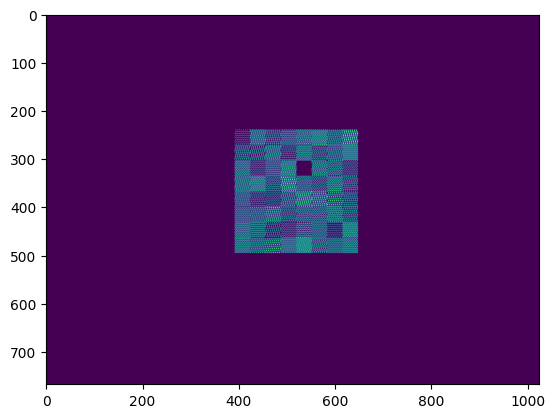

In [27]:
import os
date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
DMD_nSizeY=768
DMD_nSizeX=1024
n_actu_1D = 8
roi_size=256
# Initialisation du DMD avec une région d'intérêt (ROI)
dmd = DMDPiston(n_actu_1D, roi_size=roi_size, roi_shifts=(370, 520))  # H,V (400,520)
file=np.load(file=rf'C:\Users\gharbi\coding\PHD\PHD_1-1\mmf-field-control\notebooks\target_lign_test2_.npz')
print(file)
phi_op=file['phi_opt']
# plt.subplot(1,2,2)
# plt.imshow(np.angle(ins['phase_maps'][0]))
dmd.generate_fields(n_actu_1D, rand_amp=False, rand_phi=False,phi=None,phi_clx=phi_op)
target_field = np.copy(dmd.field_matrix)
print(target_field.shape)
plt.imshow(np.abs(target_field))
target_field /= np.max(np.abs(target_field))
# Conversion en hologramme
holo_sp = holo_SP(target_field, lut, px_comb).astype(np.uint8)
holo_sp=holo_sp*(2**8-1)
plt.imshow(holo_sp)

import threading
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING) 
imgSeq=holo_sp.ravel()
DMD.SeqAlloc(1)
DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=5000)
# Configure caméra
print("Configuring camera...")
# save_directory = f"./captured_frames_chiff0"
max_get_frame = 2
save_thread = threading.Thread(target=save_frames, args=(cam, max_get_frame))

cam.run()  # Ensure the camera is armed and ready
print("Camera is armed. Starting acquisition...")

# Start DMD projection and camera capture
  # Start the hardware trigger
DMD.Run(loop=True)
save_thread.start()
startTrigger(ser)
# Wait for threads to finish
save_thread.join()
print("Capture completed.")

# Stop the devices
cam.device.disarm()
DMD.Halt()
stopTrigger(ser)
print("All processes completed.")

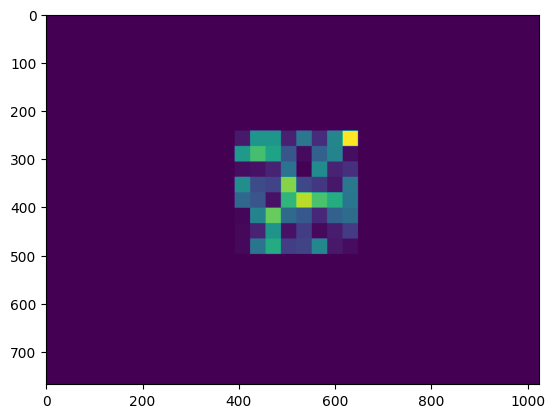

In [28]:
plt.imshow(np.abs(target_field))

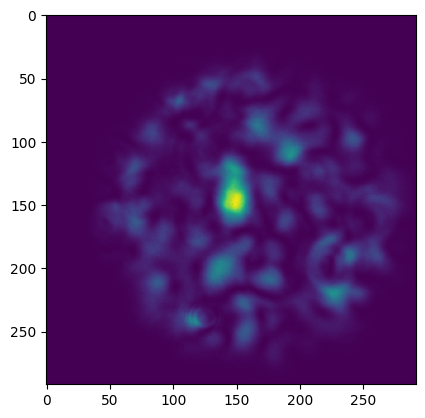

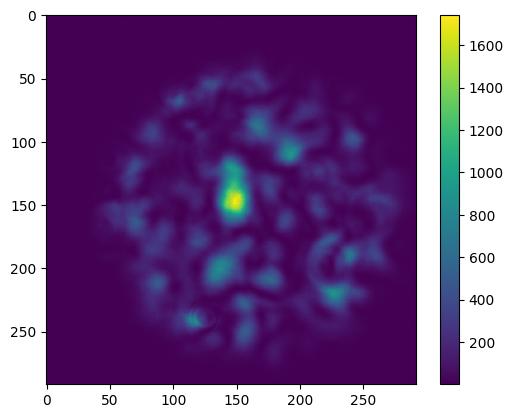

In [29]:

im=np.load(rf'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames20250129-144639.npz')

plt.figure()
plt.imshow(im['frames'][0])
plt.figure()
plt.imshow(im['frames'][1])
# plt.figure()
# plt.imshow(im['frames'][2])
plt.colorbar()

In [12]:
# Charger les deux fichiers .npz
outs = np.load(rf'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames20250129-144639.npz')
ins = np.load(rf'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256.npz')
print("Keys in outs:", list(outs.keys()))
print("Keys in ins:", list(ins.keys()))
datasets = {
    'intens': outs['frames'],  # Renamed 'frames' to 'intens'
    'phase_maps': ins['phase_maps'][:20000]  # Added 'phase_maps' from ins
}
import time
nbr_holos = 20000  # Replace with the actual number of holos
n_actu_1D = 8    # Replace with the actual number of actuators
datasets_npz_file_path = rf'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\datasets_of_{nbr_holos}_1D_Actu_{n_actu_1D}_at_{date_str}.npz'

np.savez(datasets_npz_file_path, **datasets)
print(f"Dataset saved to {datasets_npz_file_path}")



Keys in outs: ['frames']
Keys in ins: ['Holos_Actu', 'phase_maps']
Dataset saved to C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\datasets_of_20000_1D_Actu_8_at_20250129-144639.npz


Clés dans le fichier .npz combiné : ['intens', 'phase_maps']


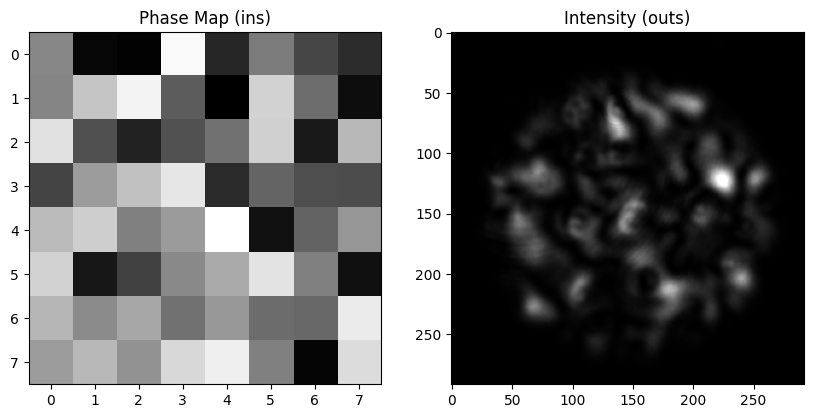

In [74]:
# Vérification du contenu du fichier .npz
loaded_npz = np.load(datasets_npz_file_path)
print("Clés dans le fichier .npz combiné :", loaded_npz.files)

# Visualisation des premières images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Phase Map (ins)")
plt.imshow(np.abs(loaded_npz['phase_maps'][0]), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Intensity (outs)")
plt.imshow(loaded_npz['intens'][0], cmap='gray')
plt.show()

# Verifs

In [10]:
import threading
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING)


# Load holograms
ins = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256.npz')
Holos_num = ins['Holos_Actu'][:15000]
nbr_holos = len(Holos_num)
print('Number of holograms:', nbr_holos)

# Flatten holograms into a single sequence
imgSeq = np.concatenate([img.ravel() for img in Holos_num])
print("Image sequence min/max:", imgSeq.min(), imgSeq.max())

# Allocate sequence for DMD
DMD.SeqAlloc(nbr_holos)
DMD.SeqPut(imgSeq)
DMD.SetTiming(pictureTime=5000)
max_get_frame = nbr_holos

# Start thread to save frames from camera
save_thread = threading.Thread(target=save_frames, args=(cam, max_get_frame))
cam.run()
DMD.Run(loop=False)
save_thread.start()
startTrigger(ser)
save_thread.join()
cam.device.disarm()
DMD.Halt()
stopTrigger(ser)



Number of holograms: 15000
Image sequence min/max: 0 255
SequenceId =  c_long(2)
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Frame 1:
  Frame count: 1
  Time stamp: 28788242702646
Frame 2:
  Frame count: 2
  Time stamp: 28788251234686
Frame 3:
  Frame count: 3
  Time stamp: 28788259772101
Frame 4:
  Frame count: 4
  Time stamp: 28788268309757
Frame 5:
  Frame count: 5
  Time stamp: 28788276846676
Frame 6:
  Frame count: 6
  Time stamp: 28788285383282
Frame 7:
  Frame count: 7
  Time stamp: 28788293919565
Frame 8:
  Frame count: 8
  Time stamp: 28788302452909
Frame 9:
  Frame count: 9
  Time stamp: 28788310985949
Frame 10:
  Frame count: 10
  Time stamp: 28788319521909
Frame 11:
  Frame count: 11
  Time stamp: 28788328058515
Frame 12:
  Frame count: 12
  Time stamp: 28788336595414
Frame 13:
  Frame count: 13
  Time stamp: 28788345131383
Frame 14:
  Frame count: 14
  Time stamp: 28788353664424
Frame 15:
  Frame count: 15
  Time stamp: 28788362197585
Fram

In [30]:
DMD.Halt()
DMD.FreeSeq()

# shaping

NpzFile 'C:\\Users\\gharbi\\coding\\PHD\\PHD_1-1\\mmf-field-control\\notebooks\\target_spot_.npz' with keys: target_field, props, phi_opt, mmf_field, z_field...
imgSeq min/max: 0 255
SequenceId =  c_long(12)
Configuring camera...
Current frames_per_trigger: 1
Camera armed and ready for hardware triggering.
Camera is armed. Starting acquisition...
Frame 1:
  Frame count: 1
  Time stamp: 284859738264787
Total acquisition time: 1013298.51 µs
Captured 1 frames successfully.
Saved all frames to ./captured_frames1737998069.2350879
Capture completed.
All processes completed.


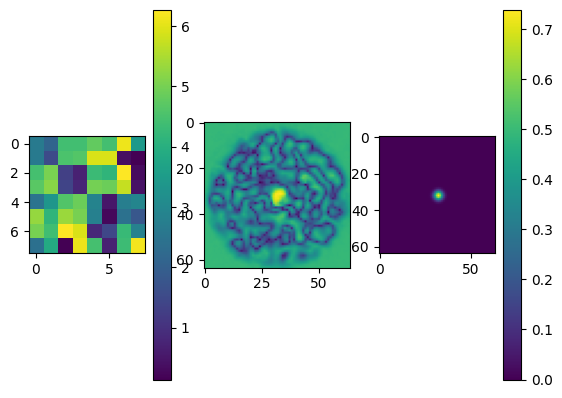

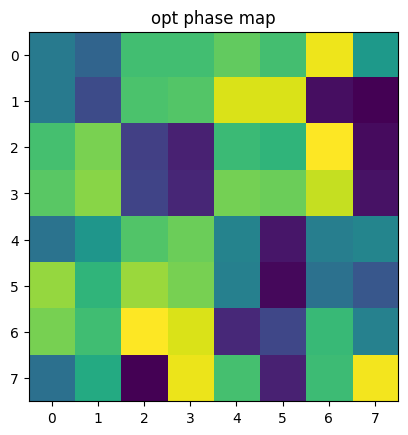

In [46]:
import threading
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING) 
# ins = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=500_1D_8_ROI256.npz')
ins=np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\mmf-field-control\notebooks\target_spot_.npz')
print(ins)
target_field = ins['target_field']
phi_opt = ins['phi_opt'][0]
mmf_field = ins['mmf_field']
# loss_list = ins['loss_list']
plt.figure()
plt.subplot(1,3,2)
plt.imshow(np.sqrt(np.abs(mmf_field)))

plt.subplot(1,3,1)
plt.imshow(phi_opt)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.sqrt(np.abs(target_field)))
plt.colorbar()

DMD_nSizeY=768
DMD_nSizeX=1024
n_actu_1D = 8
roi_size=256
# Initialisation du DMD avec une région d'intérêt (ROI)
dmd = DMDPiston(n_actu_1D, roi_size=roi_size, roi_shifts=(370, 520)) 
dmd.generate_fields(n_actu_1D, rand_amp=False, rand_phi=False,phi=phi_opt)
phi_opt_holo = np.copy(dmd.field_matrix)
phi_opt_holo /= np.max(np.abs(phi_opt_holo))
holo_sp = holo_SP(phi_opt_holo, lut, px_comb).astype(np.uint8)
holo_sp=holo_sp*(2**8-1)




imgSeq = holo_sp.ravel()
print("imgSeq min/max:", imgSeq.min(), imgSeq.max())
DMD.SeqAlloc(1)
DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=5000)
# Configure caméra
print("Configuring camera...")
max_get_frame=1
save_thread = threading.Thread(target=save_frames, args=(cam, max_get_frame))

cam.run() 
print("Camera is armed. Starting acquisition...")

# Start DMD projection and camera capture
  # Start the hardware trigger
DMD.Run(loop=False)
save_thread.start()
startTrigger(ser)
# Wait for threads to finish
save_thread.join()
print("Capture completed.")

# Stop the devices
cam.device.disarm()
DMD.Halt()
stopTrigger(ser)

print("All processes completed.")

Clés dans le fichier combiné : ['frames']
Clés dans check_frames : ['frames']
Shape de loaded_npz['frames']: (20000, 308, 308)
Shape de check_frames['frames']: (20, 308, 308)


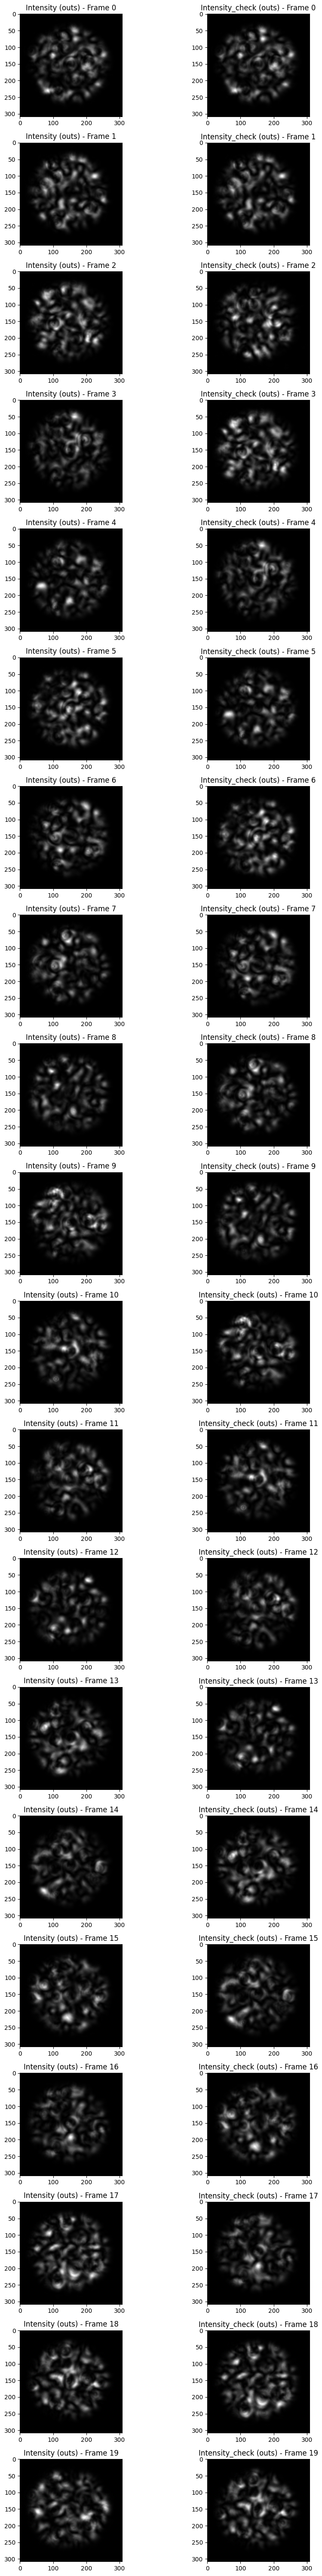

In [12]:
# Vérification du contenu du fichier .npz

loaded_npz = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames20250129-173310.npz')
check_frames = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\check_frames_at_20250129-174131.npz')

# Vérification des clés dans les fichiers chargés
# print("Clés dans le fichier combiné :", list(loaded_npz.keys()))
# print("Clés dans check_frames :", list(check_frames.keys()))

print("Clés dans le fichier combiné :", list(loaded_npz.keys()))
print("Clés dans check_frames :", list(check_frames.keys()))

# Vérification des formes des tableaux
print("Shape de loaded_npz['frames']:", loaded_npz['frames'].shape)
print("Shape de check_frames['frames']:", check_frames['frames'].shape)

# Nombre de frames dans check_frames
num_frames = len(check_frames['frames'])

# Création des sous-graphiques
# fig, axes = plt.subplots(num_frames, 1, figsize=(5, num_frames * 3))
# if num_frames == 1:
#     axes = [axes]  # S'assurer que axes est une liste si num_frames = 1

# # Affichage des images
# for i in range(num_frames):
#     ax = axes[i]
#     ax.set_title(f"Intensity_check (outs) - Frame {i}")
#     ax.imshow(check_frames['frames'][i], cmap='gray')
#     ax.axis('off')  # Supprimer les axes pour une meilleure visibilité

# plt.tight_layout()  # Ajuster automatiquement l'espacement entre les sous-graphiques
# plt.show()
# Setup the figure for subplots
plt.figure(figsize=(10, num_frames * 3))

for i in range(len(check_frames['frames'])):
    
    # Subplot for 'intens' (loaded_npz)
    plt.subplot(num_frames, 2, 2 * i + 1)
    plt.title(f"Intensity (outs) - Frame {i}")
    plt.imshow(loaded_npz['frames'][i], cmap='gray')

    # Subplot for 'frames' (check_frames)
    plt.subplot(num_frames, 2, 2 * i + 2)
    plt.title(f"Intensity_check (outs) - Frame {i}")
    plt.imshow(check_frames['frames'][i], cmap='gray')
    # Subplot for 'frames' (check_frames)
    # plt.subplot(num_frames, 3, 2 * i + 3)
    # plt.title(f"phases (ins) - Frame {i} and  ")
    # plt.imshow(loaded_npz['phase_maps'][i], cmap='gray')


        
plt.tight_layout()
plt.show()

# plt.imshow(loaded_npz['intens'][29992], cmap='gray')

In [19]:
import numpy as np
import os

file_path = r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256.npz'

loaded_npz = np.load(file_path)

phase_maps = loaded_npz['phase_maps']

indices_to_remove = np.arange(2, 3)
print(f"Indices to remove: {indices_to_remove}")

if indices_to_remove.max() < phase_maps.shape[0]:
    phase_maps_updated = np.delete(phase_maps, indices_to_remove, axis=0)
else:
    print("Erreur : Les indices à supprimer dépassent les dimensions de phase_maps.")
    phase_maps_updated = phase_maps

base, ext = os.path.splitext(file_path)
new_datasets_npz_file_path = base + '_updated' + ext

np.savez(new_datasets_npz_file_path, phase_maps=phase_maps_updated)

print(f"Fichier mis à jour sauvegardé sous : {new_datasets_npz_file_path}")


Indices to remove: [2]
Fichier mis à jour sauvegardé sous : C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=30000_1D_8_ROI256_updated.npz


In [48]:
import os
import numpy as np
import shutil

# Dossier contenant les anciens fichiers .npy
old_folder = r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames1738057800.9000611.npz'

# Charger les fichiers .npy du dossier
outs = sorted(os.listdir(old_folder))  # Trier les fichiers pour assurer l'ordre
ins = []  # Liste pour stocker les images chargées
for file in outs[:3]:  # Charger les 3 premières images
    filepath = os.path.join(old_folder, file)
    frame = np.load(filepath)  # Charger le fichier .npy
    ins.append(frame)

# Charger le fichier .npz contenant les nouvelles images
new_file = r'combined_frames.npz'  # Le fichier contenant les images combinées
new_frames = np.load(new_file)['frames']  # Charger le tableau 'frames' du fichier .npz

# Comparer les 3 premières images
for i in range(3):
    if np.array_equal(ins[i], new_frames[i]):
        print(f"Image {i}: Identique")
    else:
        print(f"Image {i}: Différente")

# Supprimer l'ancien dossier si toutes les images sont identiques
if all(np.array_equal(ins[i], new_frames[i]) for i in range(3)):
    shutil.rmtree(old_folder)  # Supprime le dossier
    print("Ancien dossier supprimé :", old_folder)
else:
    print("Les images ne correspondent pas. Vérification requise.")


Image 0: Identique
Image 1: Identique
Image 2: Identique
Ancien dossier supprimé : C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames_chiff0


['frame_0_3843823291242.npy', 'frame_1000_3852391376080.npy', 'frame_1001_3852399919595.npy', 'frame_1002_3852408462181.npy', 'frame_1003_3852417005383.npy', 'frame_1004_3852425548606.npy', 'frame_1005_3852434087616.npy', 'frame_1006_3852442631131.npy', 'frame_1007_3852451174353.npy', 'frame_1008_3852459716929.npy', 'frame_1009_3852468260141.npy', 'frame_100_3844677519080.npy', 'frame_1010_3852476803353.npy', 'frame_1011_3852485343000.npy', 'frame_1012_3852493886202.npy', 'frame_1013_3852502429424.npy', 'frame_1014_3852510972000.npy', 'frame_1015_3852519515212.npy', 'frame_1016_3852528058727.npy', 'frame_1017_3852536601313.npy', 'frame_1018_3852545144525.npy', 'frame_1019_3852553687737.npy', 'frame_101_3844686062282.npy', 'frame_1020_3852562230313.npy', 'frame_1021_3852570770272.npy', 'frame_1022_3852579313494.npy', 'frame_1023_3852587852494.npy', 'frame_1024_3852596395717.npy', 'frame_1025_3852604938919.npy', 'frame_1026_3852613481818.npy', 'frame_1027_3852622025020.npy', 'frame_1028_

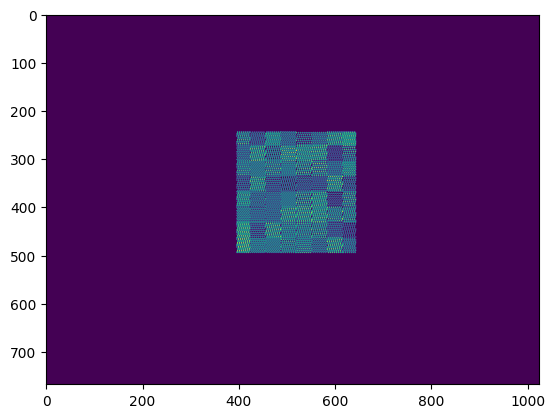

In [23]:
save_directory = r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\captured_frames_chiff0'
outs = sorted(os.listdir(save_directory))
print(outs)

save_directory = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=10000_1D_8_ROI250.npz')
ins = save_directory['Holos_Actu']
print(ins.shape)
plt.imshow(ins[1,:,:])

Nouvelle forme des données : (10000, 250, 250)


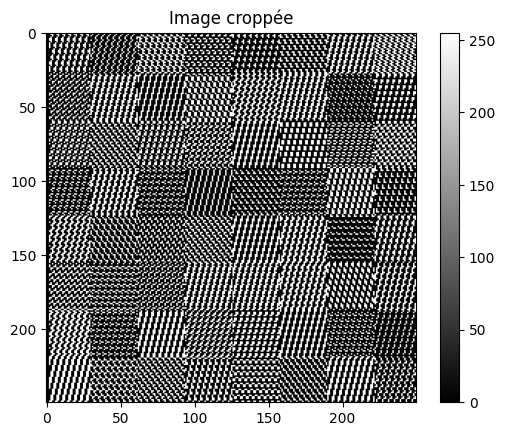

In [32]:
# Indices pour cropper la zone centrale
center_y, center_x = 768 // 2 -15, 1024 // 2+7  # Centre de l'image
crop_size = 250  # Taille du crop
half_crop = crop_size // 2

start_y, end_y = center_y - half_crop, center_y + half_crop
start_x, end_x = center_x - half_crop, center_x + half_crop

# Cropping de toutes les images
cropped_ins = ins[:, start_y:end_y, start_x:end_x]

# Vérification de la nouvelle forme
print("Nouvelle forme des données :", cropped_ins.shape)  # (10000, 250, 250)

# Visualiser une image croppée
plt.imshow(cropped_ins[1, :, :], cmap='gray')
plt.colorbar()
plt.title("Image croppée")
plt.show()

np.savez('cropped_phase_maps_images.npz', cropped_ins=cropped_ins)


# HOLOS_CHIFFRES

### generaation des images de chiffres en png 

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# Taille de l'image
image_height = 768
image_width = 1024

# Répertoire de sauvegarde des images
save_directory = "./digit_images"
os.makedirs(save_directory, exist_ok=True)

font_size = 300
font_path = "arial.ttf"
try:
    font = ImageFont.truetype(font_path, font_size)
except IOError:
    print(f"Erreur : Impossible de charger la police '{font_path}'. Veuillez vérifier le chemin.")
    raise

# Génération des images
for digit in range(0, 10):  # Chiffres de 0 à 9
    # Créer une image vide (noire)
    image = Image.new("L", (image_width, image_height), 0)
    draw = ImageDraw.Draw(image)
    
    # Taille du texte
    text = str(digit)
    bbox = font.getbbox(text)  # Obtenir les dimensions de la bounding box
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    # Calculer les coordonnées pour centrer le texte
    x = (image_width - text_width) // 2
    y = (image_height - text_height) // 2
    
    # Dessiner le texte (blanc, valeur 255)
    draw.text((x, y), text, fill=255, font=font)
    
    # Convertir l'image PIL en tableau NumPy
    image_array = np.array(image, dtype=np.float32)
    
    # Normaliser l'image (entre 0 et 1) avant d'appliquer holo_SP
    image_array /= np.max(image_array)
    
    # Générer l'hologramme (hypothèse : la fonction holo_SP est définie)
    image_holo = holo_SP(image_array, lut, px_comb)  # Fonction personnalisée
    
    # Convertir l'hologramme en uint8
    image_holo_uint8 = (image_holo * 255).astype(np.uint8)
    
    # Sauvegarder l'image en tant que fichier PNG
    output_image = Image.fromarray(image_holo_uint8)
    output_image.save(os.path.join(save_directory, f"digit_{digit}.png"))

print(f"Images des chiffres de 0 à 9 générées et sauvegardées dans : {save_directory}")


### images png to .npz => unit8, min/max: 0 255

In [ ]:
save_directory = "./digit_images"
chiffres = []

for digit in range(0,10):  # De 1 à 10
    image_path = os.path.join(save_directory, f"digit_{digit}.png")
    if os.path.exists(image_path):  
        
        image = Image.open(image_path)
        image_array = np.array(image, dtype=np.uint8)
        chiffres.append(image_array)
    else:
        print(f"Image non trouvée : {image_path}")


print(f"Nombre d'images chargées : {len(chiffres)}")
for i, img in enumerate(chiffres):
    print(f"Image {i+1}: shape={img.shape}, dtype={img.dtype}")
np.savez(f'C:\\Users\\gharbi\\Coding\\DLP-Shaping_Main\\holo_chiffres_0 to {len(chiffres)}.npz', 
         chiffres=np.array(chiffres))

### check holos 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_chiffres_0 to 10.npz')
chiffres = data['chiffres']
single_image=chiffres[9]
print("Image unique shape:", single_image.shape)
print("Image unique dtype:", single_image.dtype)
print("Image unique min/max:", single_image.min(), single_image.max())
plt.imshow(chiffres[9])

In [ ]:
from fonctions_utiles import extract_npz_content as npz
npz(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_Young_Amp_Phase.npz')

In [10]:
ser.close()
print("Port COM3 is released.")

Port COM3 is released.


# records no Cam 

In [7]:
import threading
DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING) 
data = np.load(r'C:\Users\gharbi\coding\PHD\PHD_1-1\DLP-Shaping_Main\holo_Acuators_size=10000_1D_8_ROI250.npz')
Holos_num = data['Holos_Actu']
# Extraction d'une image unique pour Verif
single_image = Holos_num[0].ravel()
print("Image unique shape:", single_image.shape)
print("Image unique dtype:", single_image.dtype)
print("Image unique min/max:", single_image.min(), single_image.max())

# imgSeq = np.concatenate([img.ravel() for img in Holos_num])
imgSeq=single_image
print(len(single_image))
print("imgSeq min/max:", imgSeq.min(), imgSeq.max())
DMD.SeqAlloc(len(single_image))
DMD.SeqPut(imgSeq)
DMD.SetTiming( pictureTime=8000)

startTrigger(ser)  # Start the hardware trigger
DMD.Run(loop=True)


# DMD.Halt()

Image unique shape: (786432,)
Image unique dtype: uint8
Image unique min/max: 0 255
786432
imgSeq min/max: 0 255


ALPError: The requested memory is not available (full?).

In [5]:
# cam.device.disarm()
DMD.Halt()
DMD.FreeSeq()

ValueError: list.remove(x): x not in list

In [40]:

DMD.Halt()
DMD.FreeSeq()
DMD.Free()

ValueError: list.remove(x): x not in list

In [28]:
cam.dispose()

# Test individuel

## with tot AOI

## Display the Holos in SLave Mode 

In [8]:
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

# Subtract 10µs because if the picture time is roughly the same as the time between two triggers,
# some triggers might be missed.
# SynchPulseWidth ≤ PictureTime - TriggerInDelay - 1 µs

data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\Holos_Actu_ROI_0.npz')
print (data)
Holos_Actu = data['Holo']

# Configure the DMD for projection
# DMD.ProjControl(ALP_PROJ_MODE, ALP_SLAVE)  # Set projection to slave mode
# DMD.DevControl(ALP_TRIGGER_EDGE, ALP_EDGE_RISING)  # Set rising edge triggering

import time

max_frame_nbr=100
nbImg = 1 #Holos_Actu.shape[0]
bitDepth = 1
sequence_id = DMD.SeqAlloc(nbImg=nbImg, bitDepth=bitDepth)

Holos_Actu_1d = Holos_Actu.ravel()  # Ou Holos_Actu.flatten()
DMD.SeqPut(Holos_Actu_1d, sequence_id)  # Conversion en liste si nécessaire

DMD.SetTiming(  pictureTime=3000)
DMD.Run(sequence_id,loop=True)
# cam.get_snapshot_hardware_trigger(
#     save_directory=f"./captured_frames{time.time()}",
#     display_timer=True,
#     max_get_frame=max_frame_nbr,
#     debug=True,
# )

# frame = np.load("./captured_frames/frame_123456789.npy")
# plt.imshow(frame, cmap="gray")
# plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gharbi\\Coding\\DLP-Shaping_Main\\Holos_Actu_ROI_0.npz'

In [136]:
DMD.Halt()

## Def AOI

seq.shape (148, 1024)
SequenceId =  c_long(1)


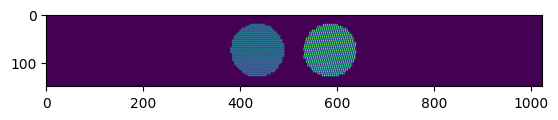

In [7]:
nWidth = DMD.nSizeX #1024
nHeight = DMD.nSizeY #768


LineLoad=150 # lines to load 


r1 =55
r2 = r1
spacing =150
hologram = generate_interference_hologram(r1, r2, spacing, phase=np.pi)

mid_H=hologram.shape[0]//2
mid_Load=LineLoad//2

target_field = hologram[mid_H-mid_Load:mid_H+mid_Load]
target_field /= np.max(np.abs(target_field))


bitDepth = 1
holo_sp=holo_SP(target_field,lut,px_comb)
seq = holo_sp * (2**8-1)

print("seq.shape",seq.shape)
plt.imshow(seq)
if isinstance(seq, list):
    seq = np.array(seq, dtype=np.uint8)



DMD.SeqAlloc(nbImg = 1, bitDepth = bitDepth)

DMD.SeqPutEx(
    imgData=seq,
    LineOffset= 0,
    LineLoad=LineLoad,
    PicOffset=0,  
    PicLoad=1,   
    dataFormat="Python"
)
DMD.SetTiming(
    illuminationTime=5000)
DMD.Run(loop=True)

# DMD.Halt()

# Generation des Holo de Young 

In [18]:

def generate_interference_hologram(radius1, radius2, spacing, H_size=768, W_size=1024, amp=1, phase=np.pi/2, amp_ref=0.1):
    H_size = int(H_size)
    W_size = int(W_size)
    x = np.linspace(-W_size // 2, W_size // 2, W_size)
    y = np.linspace(-H_size // 2, H_size // 2, H_size)
    X, Y = np.meshgrid(x, y)
    
    dist1 = np.sqrt((X + spacing / 2) ** 2 + Y ** 2)  
    dist2 = np.sqrt((X - spacing / 2) ** 2 + Y ** 2)  

    circle1 = np.where(dist1 <= radius1, 1, 0) 
    circle2 = np.where(dist2 <= radius2, 1, 0)  

    GL_ref = amp_ref * circle1
    GL = amp * np.exp(1j * phase) * circle2
    hologram = GL_ref + GL
    
    return hologram

# Vérification GPU
if not cp.cuda.runtime.getDeviceCount():
    raise RuntimeError("Aucun GPU compatible CUDA détecté.")



## Complex Young Holos calculation

In [31]:
from scipy.ndimage import rotate

spacing=60
radius1=8
amp_step = 0.1
phi_step = 2 * np.pi /32

amplitudes = np.linspace(0, 1, int(1 / amp_step))
phases = np.linspace(0, 2 * np.pi, int(2 * np.pi / phi_step) + 1)    
amp_ref = 1  

Holos=[]
amps=[]
phi=[]
i=0


for amp in amplitudes:
    for phase in phases:
        print("loop nbr =", i, "amp =", amp, "phase =", phase)
        hologram = generate_interference_hologram(radius1, radius1, spacing, H_size=768, W_size=1024, amp=amp, phase=phase, amp_ref=amp_ref)
        
        if np.all(hologram == 0):
            raise ValueError("Le hologramme généré est entièrement nul.")
        
        # holo_sp = holo_SP(hologram, lut, px_comb, renorm=True)
        holo_sp = holo_SP(hologram, np.array(lut), np.array(px_comb), renorm=True)
        seq = (holo_sp * (2**8 - 1)).astype(np.uint8)

        i += 1
        Holos.append(seq)
        amps.append(amp)
        phi.append(phase)



loop nbr = 0 amp = 0.0 phase = 0.0
loop nbr = 1 amp = 0.0 phase = 0.19634954084936207
loop nbr = 2 amp = 0.0 phase = 0.39269908169872414
loop nbr = 3 amp = 0.0 phase = 0.5890486225480862
loop nbr = 4 amp = 0.0 phase = 0.7853981633974483
loop nbr = 5 amp = 0.0 phase = 0.9817477042468103
loop nbr = 6 amp = 0.0 phase = 1.1780972450961724
loop nbr = 7 amp = 0.0 phase = 1.3744467859455345
loop nbr = 8 amp = 0.0 phase = 1.5707963267948966
loop nbr = 9 amp = 0.0 phase = 1.7671458676442586
loop nbr = 10 amp = 0.0 phase = 1.9634954084936207
loop nbr = 11 amp = 0.0 phase = 2.1598449493429825
loop nbr = 12 amp = 0.0 phase = 2.356194490192345
loop nbr = 13 amp = 0.0 phase = 2.552544031041707
loop nbr = 14 amp = 0.0 phase = 2.748893571891069
loop nbr = 15 amp = 0.0 phase = 2.945243112740431
loop nbr = 16 amp = 0.0 phase = 3.141592653589793
loop nbr = 17 amp = 0.0 phase = 3.3379421944391554
loop nbr = 18 amp = 0.0 phase = 3.5342917352885173
loop nbr = 19 amp = 0.0 phase = 3.730641276137879
loop nbr 

## Sauvegarde des Holo et infos

In [35]:

np.savez(f'C:\\Users\\gharbi\\Coding\\DLP-Shaping_Main\\holo_Young_Amp_Phase__ amp_ref={amp_ref}_amp_step_{amp_step:.2f}___phi_step_{phi_step:.2f}.npz',
         amps=np.array(amps), 
         phases=np.array(phi), 
         Holos=np.array(Holos),
         infos=[f'spacing={spacing} ___ radius1={radius1} ___ amp_step={amp_step} ___ phi_step={phi_step:.2f} ___ amp_ref={amp_ref}'])


# display Holos For DLP Complex Charac 

In [36]:
import numpy as np
from scipy.ndimage import rotate

# Charger les données
data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_Acuators_size=10_1D_2_ROI330.npz')
Holos = data['Holos']
field = []

DMD.SeqAlloc()

for i, holo in enumerate(Holos):
    DMD.SeqAlloc()
    DMD.SeqPut(imgData=holo)
    DMD.SetTiming(illuminationTime=15000, pictureTime=None)
    DMD.Run(loop=True)
    cam.get_snapshot()
    # DMD.Wait()
    # print('still wait ?')
    im = np.copy(cam.last_frame)  
    rotated_im = rotate(im, 44, reshape=True)
    field.append(rotated_im)
    # print(f"Hologramme {i} traité.")


SequenceId =  c_long(1)
SequenceId =  c_long(2)
SequenceId =  c_long(3)
SequenceId =  c_long(4)
SequenceId =  c_long(5)
SequenceId =  c_long(6)
SequenceId =  c_long(7)
SequenceId =  c_long(8)
SequenceId =  c_long(9)
SequenceId =  c_long(10)
SequenceId =  c_long(11)


# Afiichage des franges capturés

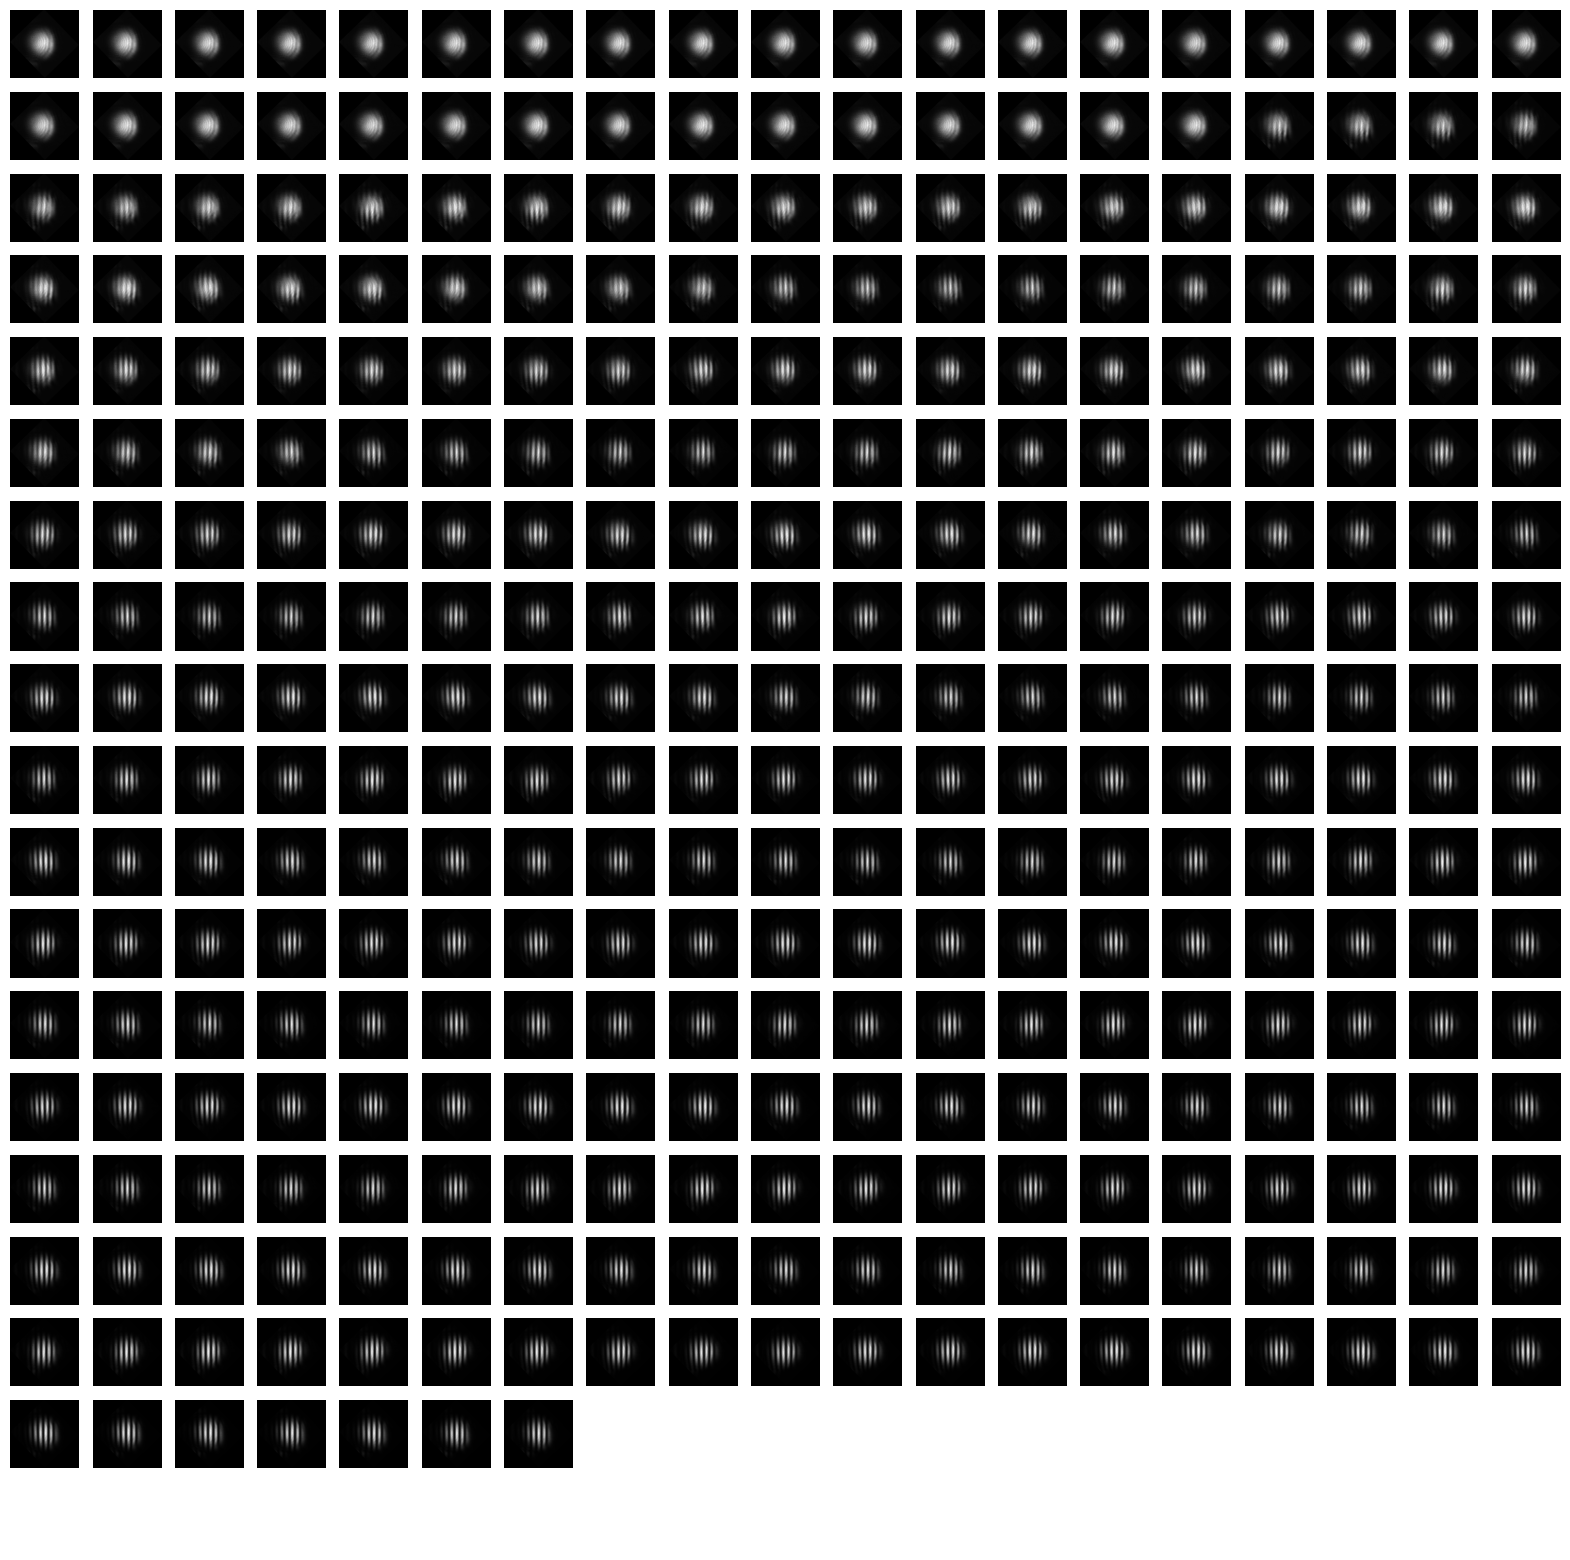

In [48]:
import numpy as np
import matplotlib.pyplot as plt

mid = int(np.ceil(np.sqrt(len(field))))
fig, axes = plt.subplots(mid, mid, figsize=(20,20))
axes = axes.ravel()
if len(field) == 1:
    print('Une seule image')
    axes[0].imshow(np.array(field[0]), cmap='gray')
    axes[0].set_title('Hologramme 0 traité')
    axes[0].axis('off')
else:
    for i, ax in enumerate(axes[:len(field)]):
        ax.imshow(np.array(field[i]), cmap='gray')
        # ax.set_title(f'Hologramme {i} traité')
        ax.axis('off')  

for ax in axes[len(field):]:
    ax.axis('off')

plt.show()


# plot the displacement

(330, 1, 517)


Text(0.5, 1.0, 'Images concaténées')

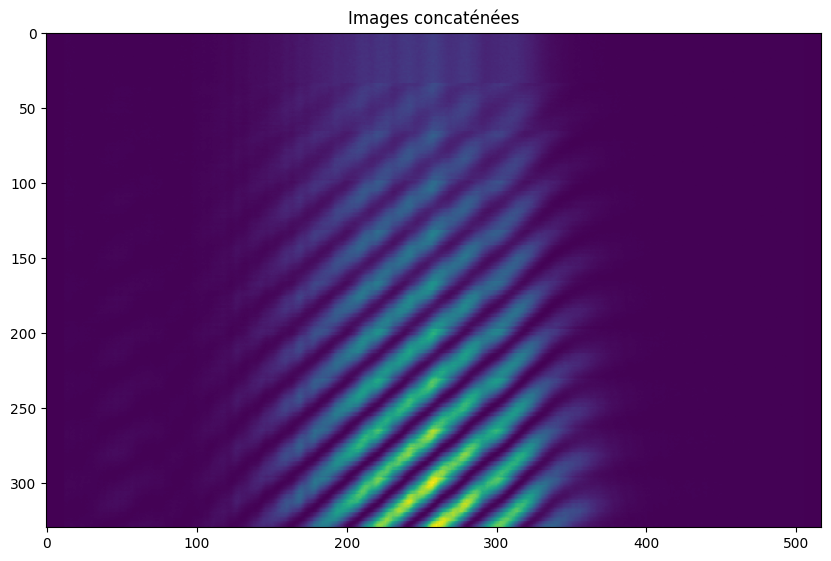

In [78]:
import matplotlib.pyplot as plt
import numpy as np

zone = field[0].shape[0] // 2

portions = [f[zone:zone+1] for f in field]
print(np.array(portions).shape)

concatenated_portions = np.vstack(portions)

plt.figure(figsize=(10, len(portions)))
plt.imshow(concatenated_portions)
plt.title("Images concaténées")

# y0 = 222
# plt.axvline(x=y0, color='red', linestyle='--', linewidth=2)
# plt.axis('on')
# plt.show()


## Specific Young holo Calc & display

In [ ]:
# amplitudes = np.linspace(0, 1, int(1 / amp_step))
spacing=60
radius1=8
hologram = generate_interference_hologram(radius1, radius1, spacing, H_size=768, W_size=1024, amp=0, phase=0, amp_ref=1)
holo_sp = holo_SP(hologram, np.array(lut), np.array(px_comb), renorm=True)
seq = (holo_sp * (2**8 - 1)).astype(np.uint8)



field_ref=[]
i=0
while i != 100:
    DMD.SeqAlloc()
    DMD.SeqPut(imgData=seq)
    DMD.SetTiming(illuminationTime=15000, pictureTime=None)
    DMD.Run(loop=True)
    cam.get_snapshot()
    # DMD.Wait()
    # print('still wait ?')
    im = np.copy(cam.last_frame)  
    rotated_im = rotate(im, 44, reshape=True)
    field_ref.append(rotated_im)
    i+=1

SequenceId =  c_long(332)
SequenceId =  c_long(333)
SequenceId =  c_long(334)
SequenceId =  c_long(335)
SequenceId =  c_long(336)
SequenceId =  c_long(337)
SequenceId =  c_long(338)
SequenceId =  c_long(339)
SequenceId =  c_long(340)
SequenceId =  c_long(341)
SequenceId =  c_long(342)
SequenceId =  c_long(343)
SequenceId =  c_long(344)
SequenceId =  c_long(345)
SequenceId =  c_long(346)
SequenceId =  c_long(347)
SequenceId =  c_long(348)
SequenceId =  c_long(349)
SequenceId =  c_long(350)
SequenceId =  c_long(351)
SequenceId =  c_long(352)
SequenceId =  c_long(353)
SequenceId =  c_long(354)
SequenceId =  c_long(355)
SequenceId =  c_long(356)
SequenceId =  c_long(357)
SequenceId =  c_long(358)
SequenceId =  c_long(359)
SequenceId =  c_long(360)
SequenceId =  c_long(361)
SequenceId =  c_long(362)
SequenceId =  c_long(363)
SequenceId =  c_long(364)
SequenceId =  c_long(365)
SequenceId =  c_long(366)
SequenceId =  c_long(367)
SequenceId =  c_long(368)
SequenceId =  c_long(369)
SequenceId =

In [ ]:
DMD.Halt()
DMD.FreeSeq()
DMD.Free()


### young hole I_ref Calc

In [ ]:
ref_moy=np.mean(field_ref,axis=0)
Eg_ref_moy=np.sum(ref_moy)
print(ref_moy ,':: ref_moy',np.min(ref_moy),':: min ref_moy ;', np.max(ref_moy),':: max ref_moy ;',Eg_ref_moy,':: Eg_ref_moy')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] :: ref_moy 0.0 :: min ref_moy ; 914.61 :: max ref_moy ; 17622802.03 :: Eg_ref_moy


## Plot the fringe path Func

In [50]:
def track_fringe(concatenated_image, initial_position=None, search_range=10):
    size = concatenated_image.shape[1]
    if initial_position is None:
        initial_position = np.argmax(concatenated_image[0,:])

    tracked_positions = []
    for i in range(concatenated_image.shape[0]):
        search_start = max(0, initial_position - search_range)
        search_end = min(size, initial_position + search_range)
        local_max_position = np.argmax(concatenated_image[i, search_start:search_end]) + search_start
        tracked_positions.append(local_max_position)
        initial_position = local_max_position
    return np.array(tracked_positions)

from scipy.optimize import curve_fit
def linear_model(x, a, b):
    return a * x + b

def fit_linear_curve(phase_shifts, displacements):
    params, _ = curve_fit(linear_model, phase_shifts, displacements)
    return linear_model(phase_shifts, *params), f"y = {params[0]:.2f}x + {params[1]:.2f}"

def plot_displacement(tracked_positions, nbr_dephasages=64, save_path=None):
    phase_shifts = np.linspace(0, 2 * np.pi, nbr_dephasages)
    displacements = tracked_positions - tracked_positions[0]
    fitted_curve, equation = fit_linear_curve(phase_shifts, displacements)
    
    print('L Equation du deplacement en foction de la consigne de phase est (en µm *3.45): ', equation)
    plt.figure(figsize=(8, 6))
    plt.plot(phase_shifts, displacements, marker='o', linestyle='-', color='b', label='Données')
    plt.plot(phase_shifts, fitted_curve, linestyle='--', color='r', label=f'Ajustement: {equation}')
    plt.title("Déplacement de la frange brillante en fonction du déphasage")
    plt.xlabel("Déphasage (radians)")
    plt.ylabel("Déplacement de la frange (pixels)")
    plt.grid(True)
    plt.legend()
    plt.savefig(save_path)
    plt.show()


## Plot the fringe path 

(64, 484)
L Equation du deplacement en foction de la consigne de phase est (en µm *3.45):  y = -5.72x + -1.94


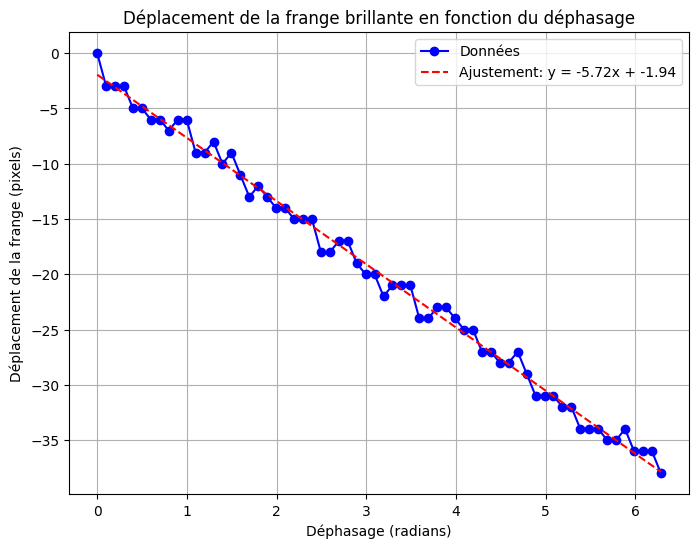

In [159]:
Res=px
dephasages=64
concatenated_image = concatenated_portions[:dephasages,:]
np.save(f'concatenated_image of {Res}pxRes_{dephasages}step.npy', concatenated_image)
print (concatenated_image.shape)
tracked_positions = track_fringe(concatenated_image,235,5)
plot_displacement(tracked_positions,nbr_dephasages=dephasages,save_path= f'{dephasages} fringes displacement in amp_phase')

# Save   I_max  / I_moy  / energie_totale

In [52]:
import numpy as np


I_max_list = []
I_moy_list = []
energie_totale_list = []

for i, f in enumerate(field):
    
    I_max = np.max(f)
    I_moy = np.mean(f)
    energie = np.sum(f)

    I_max_list.append(I_max)
    I_moy_list.append(I_moy)
    energie_totale_list.append(energie)

    print(f"capture {i} traité - I max: {I_max:.2f}, I moy: {I_moy:.2f}, Énergie: {energie:.2f}")

np.savez(f'C:\\Users\\gharbi\\Coding\\DLP-Shaping_Main\\DLP_data-analysis_ amp_ref={amp_ref}_amp_step_{amp_step:.2f}___phi_step_{phi_step:.2f}.npz',
         I_max_list=np.array(I_max_list),
         I_moy_list=np.array(I_moy_list),
         energie_totale=np.array(energie_totale_list))
        



capture 0 traité - Amp max: 471.00, Amp moy: 34.28, Énergie: 9180283.00
capture 1 traité - Amp max: 465.00, Amp moy: 33.75, Énergie: 9037926.00
capture 2 traité - Amp max: 484.00, Amp moy: 34.35, Énergie: 9200287.00
capture 3 traité - Amp max: 475.00, Amp moy: 33.99, Énergie: 9102694.00
capture 4 traité - Amp max: 487.00, Amp moy: 34.50, Énergie: 9238503.00
capture 5 traité - Amp max: 480.00, Amp moy: 34.50, Énergie: 9238585.00
capture 6 traité - Amp max: 473.00, Amp moy: 34.13, Énergie: 9141079.00
capture 7 traité - Amp max: 479.00, Amp moy: 34.59, Énergie: 9263662.00
capture 8 traité - Amp max: 478.00, Amp moy: 34.57, Énergie: 9259025.00
capture 9 traité - Amp max: 473.00, Amp moy: 34.13, Énergie: 9140634.00
capture 10 traité - Amp max: 490.00, Amp moy: 34.51, Énergie: 9242772.00
capture 11 traité - Amp max: 480.00, Amp moy: 34.37, Énergie: 9204434.00
capture 12 traité - Amp max: 478.00, Amp moy: 34.39, Énergie: 9211013.00
capture 13 traité - Amp max: 474.00, Amp moy: 34.37, Énergie:

# plot Complexe

9180282.83212
Eg_no_ref[0] -142357.0
Les valeurs négatives de EG: [-142357.0, -77589.0, -39204.0, -39649.0, -56182.0]
Indices des valeurs négatives de EG: [1, 3, 6, 9, 14]
amp_max ==  4246.487136445841
Partie réelle: [ 0.00000000e+00  8.71432073e-02  3.07711662e-02  5.45401899e-02
  4.01782753e-02  3.15900914e-02  1.78432943e-02  1.32658247e-02
  4.04626446e-18 -9.14791313e-03 -2.25274293e-02 -2.03318415e-02
 -2.91901596e-02 -2.99122021e-02 -5.15684563e-02 -6.56441533e-02
 -7.75080058e-02 -3.31326567e-02 -8.35717613e-02 -7.49557640e-02
 -6.34350517e-02 -5.19636137e-02 -2.14430772e-02 -1.87993703e-02
 -1.65724984e-17  1.02388927e-02  3.63999448e-02  5.34685733e-02
  4.81535653e-02  9.13934950e-02  1.06007567e-01  1.13717305e-01
  1.20764185e-01  1.26002333e-01  1.80280020e-01  1.67409370e-01
  1.46236907e-01  1.21644934e-01  8.41612680e-02  6.55876340e-02
  3.25837224e-02  9.89775347e-18 -4.10087716e-02 -7.38312170e-02
 -1.16180325e-01 -1.38159372e-01 -1.54706183e-01 -1.88173973e-01
 -2

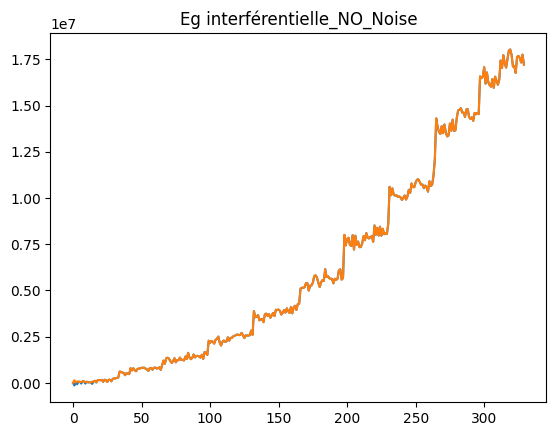

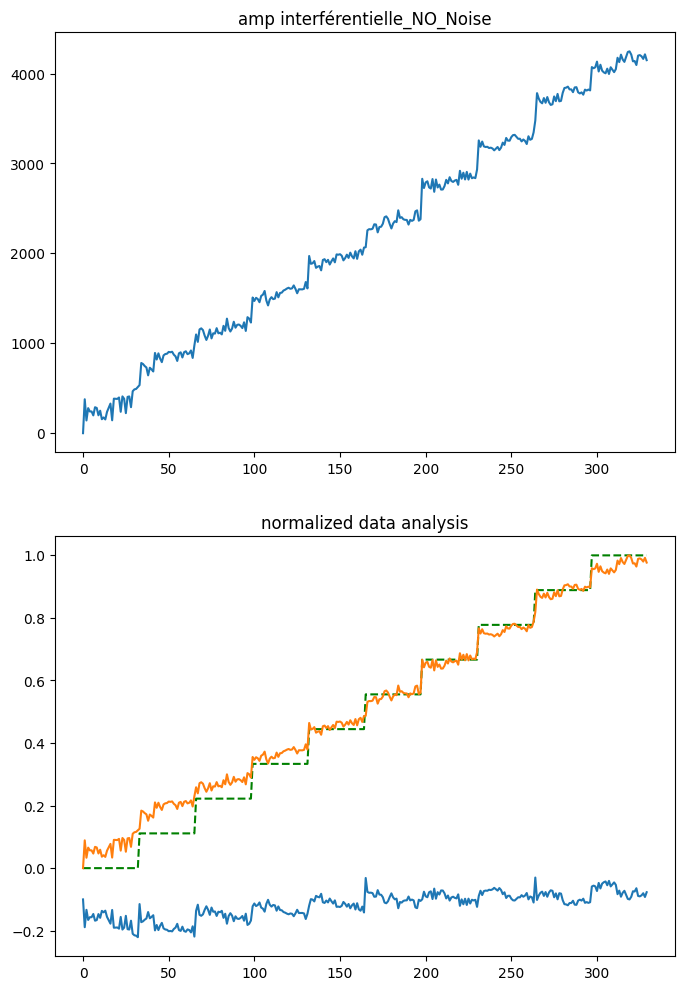

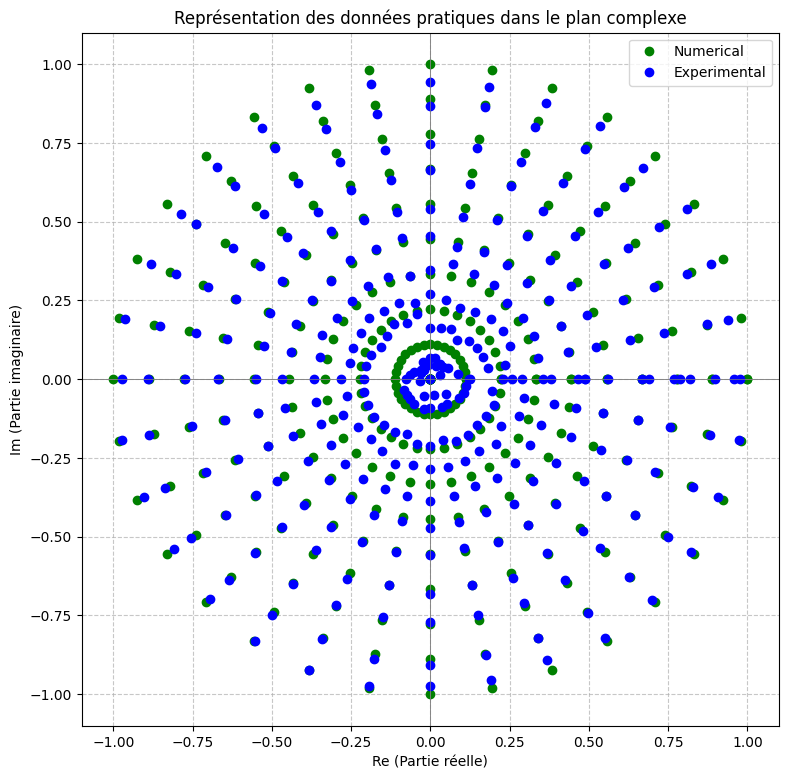

In [59]:
I_data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\DLP_data-analysis_ amp_ref=1_amp_step_0.10___phi_step_0.20.npz')
holo_data = np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\holo_Young_Amp_Phase__ amp_ref=1_amp_step_0.10___phi_step_0.20.npz')
Noise=np.load(r'C:\Users\gharbi\Coding\DLP-Shaping_Main\Noise_Data.npz')

Eg_NN = I_data['energie_totale']-0.16788
phi = holo_data['phases']
# phase=-5.72*phi-1.94
phase=phi

if len(Eg_NN) != len(phi):
    print(len(Eg_NN) , len(phi))
    raise ValueError("Les longueurs des listes 'amplitude_max' et 'phases' ne correspondent pas.")
print(Eg_NN[0])
# sans I_référence
# -np.sum(NN_patterns)
Eg_init = Eg_NN - Eg_NN[0] 
print('Eg_no_ref[0]',Eg_init[1])
print('Les valeurs négatives de EG:', [Eg_init[i] for i in range(len(Eg_init)) if Eg_init[i] < 0])
print('Indices des valeurs négatives de EG:', [i for i in range(len(Eg_init)) if Eg_init[i] < 0])
plt.figure()
plt.plot(Eg_init)
plt.plot(np.abs(Eg_init))
plt.title('Eg interférentielle_NO_Noise')

amp=np.sqrt(np.abs(Eg_init))
plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.plot(amp)
plt.title('amp interférentielle_NO_Noise')

# Theo
normalized_amplitude_theo = holo_data['amps']
real_t = normalized_amplitude_theo * np.cos(phase)
imag_t = normalized_amplitude_theo * np.sin(phase)

plt.subplot(2,1,2)
amp_max = np.max(amp)
print('amp_max == ',amp_max)
Norm_amp = amp / amp_max
plt.plot(normalized_amplitude_theo,'--', color='g' ,label='ampli_theo') 
plt.plot(normalized_amplitude_theo - Norm_amp - 0.1, label='error-0.1') 
plt.plot(Norm_amp, label='Norm_amp') 
plt.title('normalized data analysis')

# plt.legend()  

plt.figure(figsize=(9,9))
plt.plot(real_t, imag_t, 'o', color='g', label='Numerical')
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("Re (Partie réelle)")
plt.ylabel("Im (Partie imaginaire)")
plt.title("Représentation des données theoriques dans le plan complexe")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

amp_mod=Norm_amp
real_p = amp_mod * np.cos(phase)
imag_p = amp_mod * np.sin(phase)
print(f"Partie réelle: {real_p}")
print(f"Partie imaginaire: {imag_p}")

plt.plot(real_p, imag_p, 'o', color='b', label='Experimental')
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("Re (Partie réelle)")
plt.ylabel("Im (Partie imaginaire)")
plt.title("Représentation des données pratiques dans le plan complexe")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


# Loop Of 

## a Seq of 2 Predefined Phase maps 

SequenceId =  c_long(1525)
ideal actuator size= 250 


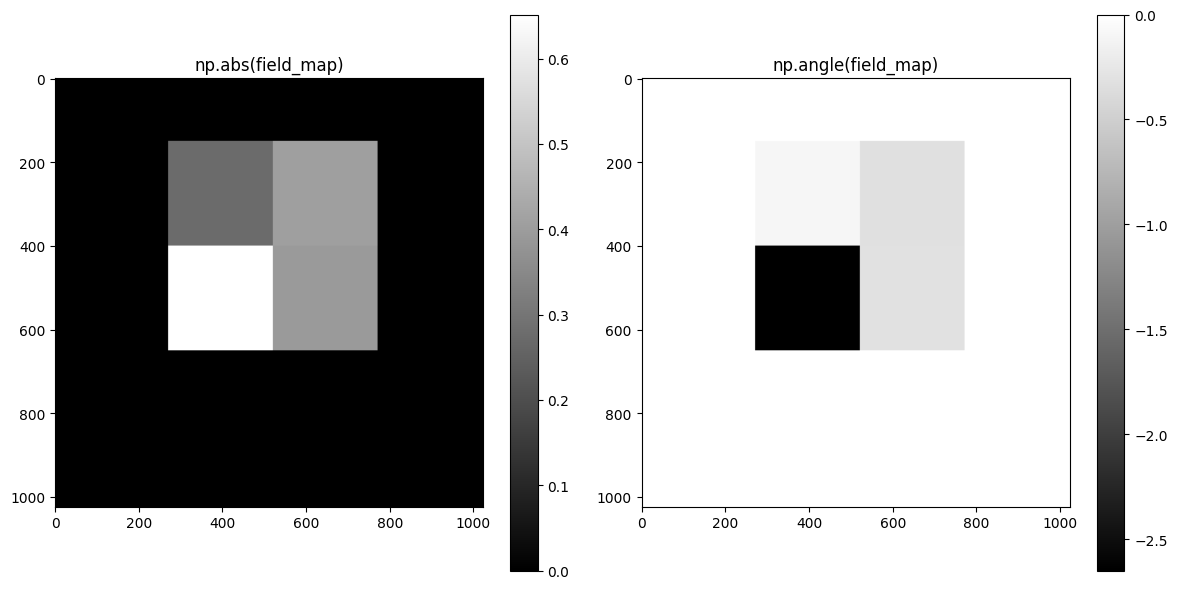

ideal actuator size= 250 


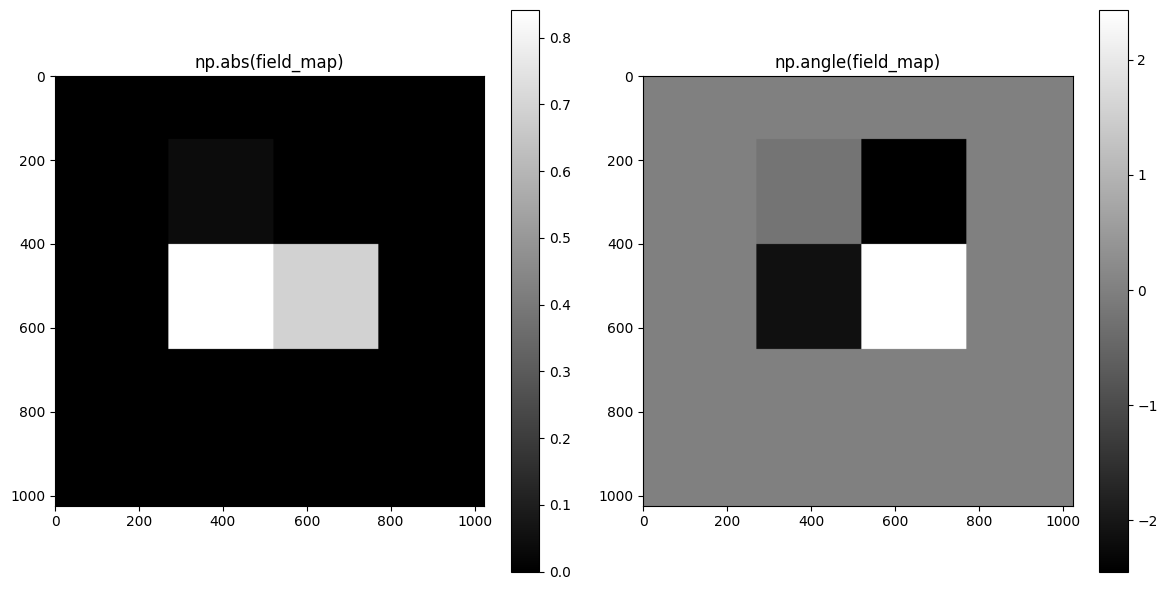

holo_1_shape = (1024, 1024) DMD.nSizeX = 1024
size OK 


In [ ]:
import time

nbImg = 2
bitDepth = 1
illumination_time = 5000
picture_time=illumination_time


n = 2
n_fields = 2
dmd = DMDPiston(n, roi_size=500,roi_shifts=(400,520))

target_fields = []
holos = []


sequence_id = DMD.SeqAlloc(nbImg=nbImg, bitDepth=bitDepth)

for i in range(n_fields):

    dmd.generate_fields(n, rand_amp=True, rand_phi=True)
    target_field = np.copy(dmd.field_matrix)
    target_field /= np.max(np.abs(target_field))

    holo = holo_SP(target_field, lut, px_comb)
    holo = holo * (2**8-1)

    target_fields.append(target_field)
    holos.append(holo)


print("holo_1_shape =",holos[0].shape,"DMD.nSizeX =",DMD.nSizeX)

if holos[0].shape[0] != DMD.nSizeX :
    print("probleme de dimention")
else : print ("size OK ")

if isinstance(holos, list):
    holos = np.array(holos, dtype=np.uint8)

DMD.SeqPut(holos,sequence_id)
DMD.SetTiming(
        illuminationTime=illumination_time,
        pictureTime=picture_time)
DMD.Run(sequence_id,loop=True)



# Halt

In [ ]:
DMD.Halt()
DMD.FreeSeq()

In [ ]:
DMD.Free()

# show young holes holos 

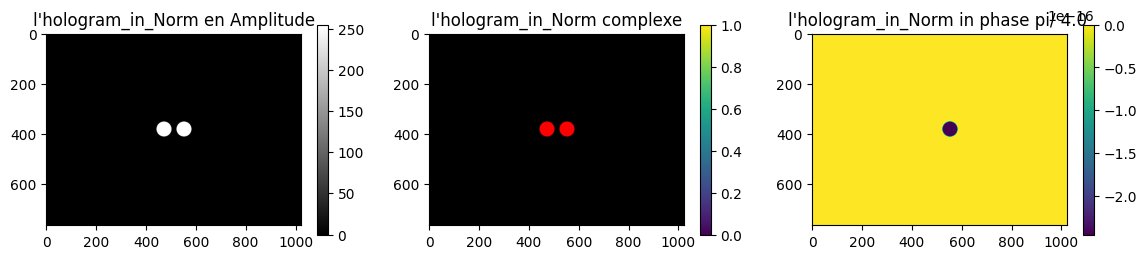

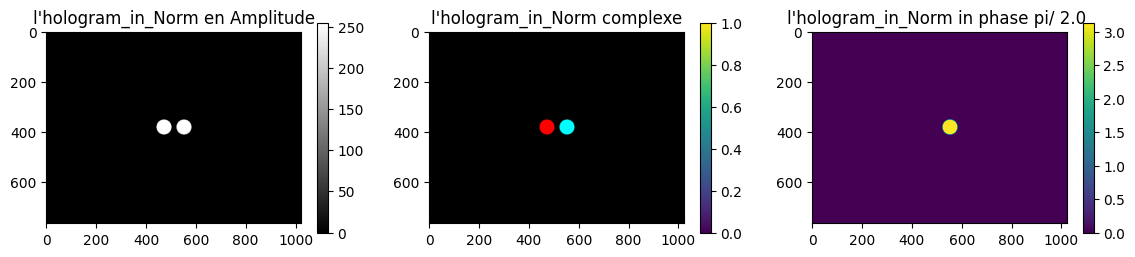

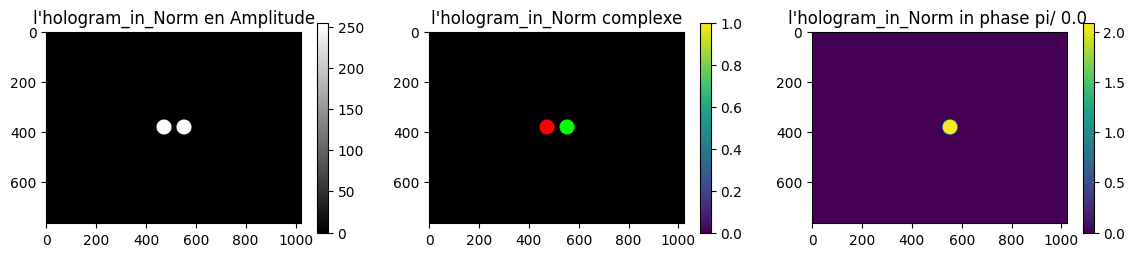

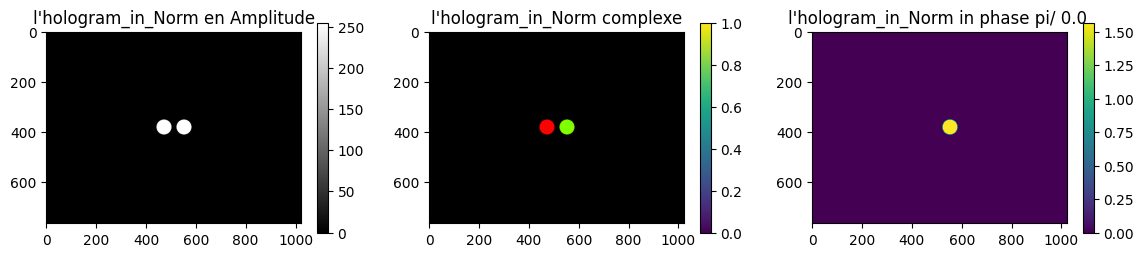

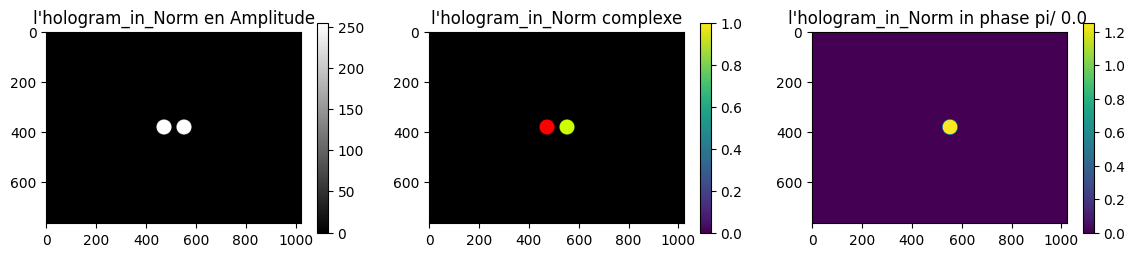

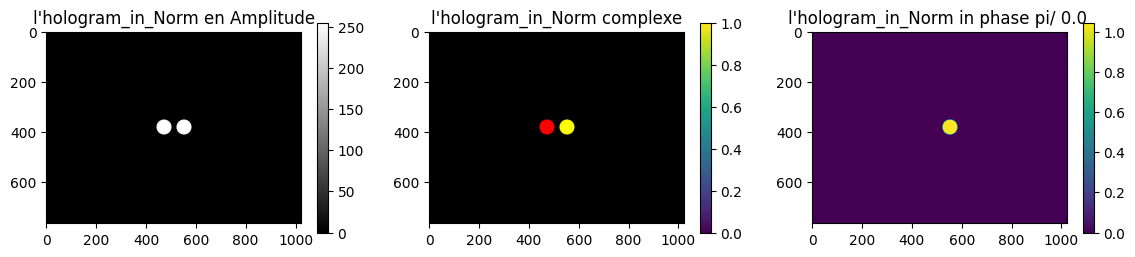

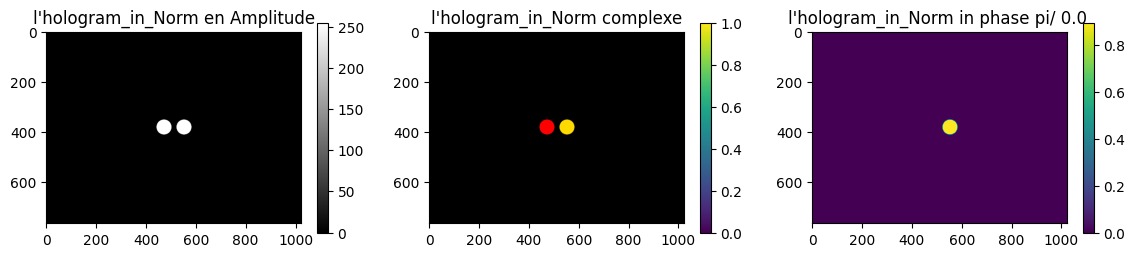

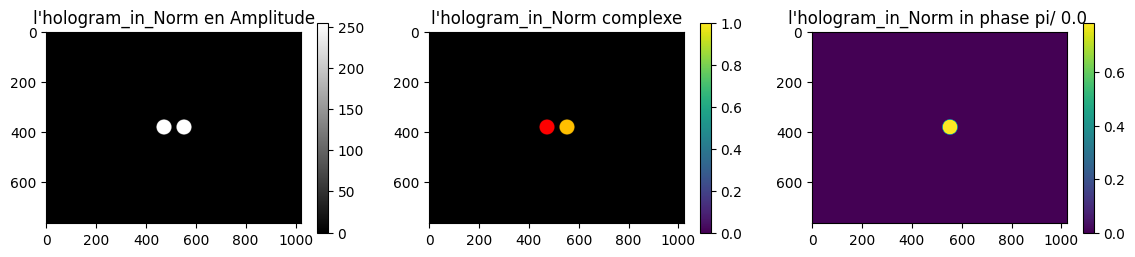

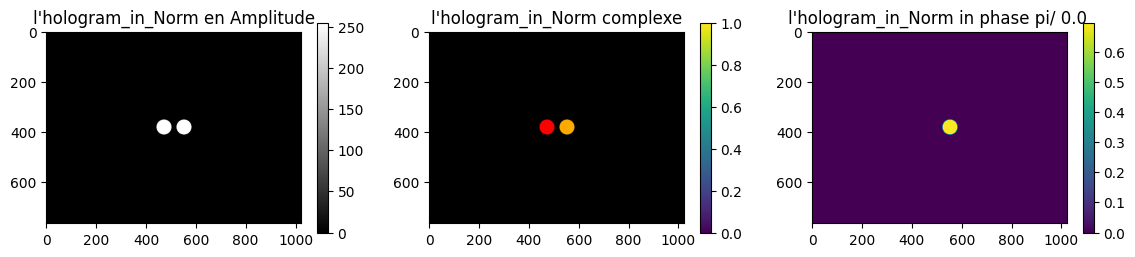

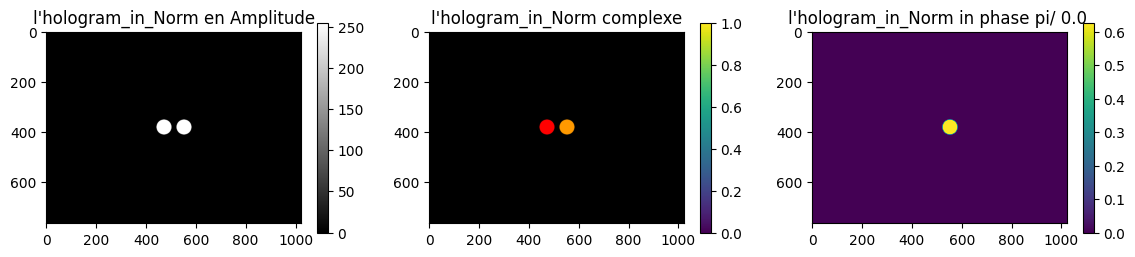

In [26]:
for i in range(10):
    phi_i=np.pi*2/(i+1)
    
    hologram_in = generate_interference_hologram(radius1=30, radius2=30, spacing=80, phase=phi_i,amp_ref=1)
    hologram_in_Norm = hologram_in / np.max(np.abs(hologram_in))
    
    # Transformation et enregistrement sur le DMD
    # holo_sp = holo_SP(hologram_in_Norm, lut, px_comb)
    seq = (hologram_in_Norm * (2**8 - 1))
    plt.figure(figsize=(14,6))
    
    plt.subplot(2,3,1)
    plt.imshow(np.abs(seq), cmap='gray')
    plt.title("l'hologram_in_Norm en Amplitude")
    plt.colorbar()
    plt.subplot(2,3,2)
    plt.imshow(colorize(seq))
    plt.title("l'hologram_in_Norm complexe")
    plt.colorbar()
    plt.subplot(2,3,3)
    plt.imshow(np.angle(seq))
    plt.title(f"l'hologram_in_Norm in phase pi/ {phi_i//np.pi*2} ")
    plt.colorbar()
    
    
    # plt.subplot(2,3,4)
    # plt.imshow(np.abs(holo_sp), cmap='gray')
    # plt.title("l'hologramme SP en Amplitude")
    # plt.colorbar()
    # plt.subplot(2,3,5)
    # plt.imshow(np.abs(seq))
    # plt.title("l'seq abs ")
    # plt.colorbar()
    # plt.subplot(2,3,6)
    # plt.imshow(np.angle(holo_sp))
    # plt.title("l'hologramme_SP in phase")
    # plt.colorbar()

# show FT

In [ ]:
shaped_field, ft_holo = fourier_filter(holo_sp, nuvec, SA_filter, get_ft=True)
ft_holo_int = np.square(np.abs(ft_holo))
ft_holo_log = 10 * np.log10(ft_holo_int)

sh = np.array(ft_holo_log).shape
ap_loc = nuvec
ap_rad = SA_filter

err_amp = np.abs(shaped_field) - np.abs(target_field)
err_amp_norm = np.abs(shaped_field) / np.max(np.abs(shaped_field)) - np.abs(target_field) / np.max(np.abs(target_field))
err_phi = np.angle(np.exp(1j * (np.angle(shaped_field) - np.angle(target_field))))
fig = plt.figure(figsize=(15, 7))

plt.subplot(1, 4, 1)
plt.imshow(holo_sp, cmap='gray')
plt.title('Hologram superpixel')
plt.colorbar(location = 'bottom')

plt.subplot(1, 4, 2)
ax = plt.gca()
plt.imshow(ft_holo_log, cmap='plasma', vmax=np.max(ft_holo_log), vmin=np.max(ft_holo_log)-40)
ax.add_patch(
    Ellipse(
        np.array(sh)/2-ap_loc*np.array(sh), 
        width=2*ap_rad*sh[0],
        height=2*ap_rad*sh[1],
        edgecolor='white',
        facecolor='none',
        linewidth=2,
    )
)
plt.title('Fourier intensity (dB)')
plt.colorbar(location = 'bottom')

plt.subplot(1, 4, 3)
plt.imshow(colorize(shaped_field))
plt.title('Shaped field')

plt.subplot(1, 4, 4)
plt.imshow(colorize(target_field))
plt.title('Target field')

plt.show()


fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
plt.imshow(np.abs(target_field), cmap='gray')
plt.title('Normalized Target amplitude')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(shaped_field), cmap='gray')
plt.title('Normalized Shaped amplitude')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 3)
plt.imshow(err_amp_norm, cmap='bwr')
plt.title('Amplitude error')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 4)
plt.imshow(np.angle(target_field), cmap='hsv')
plt.title('Target phase')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 5)
plt.imshow(np.angle(shaped_field), cmap='hsv')
plt.title('Shaped phase')
plt.colorbar(location = 'bottom')

plt.subplot(2, 3, 6)
plt.imshow(err_phi, cmap='bwr')
plt.title('Phase error')
plt.colorbar(location = 'bottom')


plt.show()

# Crops

In [ ]:
crop = (holos.shape[0] - DMD.nSizeY) // 2
cropped_holos = np.array([np.roll(np.roll(holo[crop:-crop, :], shift=np.random.randint(1000), axis=0), shift=np.random.randint(1000), axis=1) for holo in holos])

In [55]:
cropped_holos

array([], shape=(1, 0, 512), dtype=int32)

In [23]:
# Stop the sequence display
DMD.Halt()

In [26]:
# Free the sequence from the onboard memory
DMD.FreeSeq()
# De-allocate the device
DMD.Free()

### The AlpSeqPutEx function offers the same functionality as the standard function (AlpSeqPut), but in addition, it is possible to select a section within a sequence frame using the LineOffset and LineLoad parameters of the tAlpLinePut data-structure
## We only passe the lines of the pictures we want to update via the UserArrayPtr(that would be PicLoad*LineLoad lines in total).

DMD.SetTiming(  
    SequenceId = None,

    #----------------------------------          
   
""" illuminationTime : Durée d'affichage de chaque image (en µs).

    pictureTime : Intervalle entre deux images consécutives.

    synchDelay : Délai entre l'impulsion de synchronisation et le début de l'affichage.

    synchPulseWidth : Durée de l'impulsion de synchronisation.

    triggerInDelay : Délai du signal de déclenchement entrant (si utilisé).
    
"""
    #--------------------------------------------------------------------  
                      
    synchDelay = None, 
    \
    synchPulseWidth = None, 
    triggerInDelay = None)
